In [5]:

print('Started Python Code (inside)')
import os
import numpy as np
from numpy import savetxt
import pandas as pd
import glob

#import matplotlib
#matplotlib.use('Agg')  # Use the 'Agg' backend for non-GUI operations
import matplotlib.pyplot as plt

#from IPython.display import display, HTML

import tensorflow as tf
#from keras.utils.vis_utils import plot_model
#from keras.preprocessing.sequence import TimeseriesGenerator

from scipy.io import loadmat

#import xgboost as xgb
#import lightgbm as lgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.svm import SVC   #for Support Vector Machine (SVM) Algorithm

from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn.svm import SVC   #for Support Vector Machine (SVM) Algorithm
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing

import mne
from mne.stats import permutation_cluster_test
from timeit import default_timer as timer 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

from confidenceinterval import roc_auc_score
import copy
#from tdqm import tdqm

from scipy.stats import ttest_ind, ttest_1samp
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import convolve2d

import sys
#sys.path.append('C:/GitHub/ML_models/Whether_Project/')
#from custumBoost_matrix import CustomFeatureFabrique  

import pickle
import re

class ExperimentData:
    def __init__(self, epochs = [], groups = [], phase= [], stim= [], subj= [], triggers= []):
        self.data = epochs
        self.groups = groups
        self.phase = phase
        self.stimulus = stim
        self.subject_id = subj
        self.triggers = triggers
        self.labels = []
        self.include_patterns = []
        self.exclude_patterns = []
        self.num_splits = 4

    def load_and_concatenate_specific_pickles(self):
        all_epochs = []
        all_triggers = []
        all_labels = []
        all_phase = []
        all_stimuli = []
        all_subjects = []
        all_new_labels = []

        count = 0;
        for root, dirs, files in os.walk(self.folder_path):
            for file in files:
                if file.endswith(".pkl") and all(pattern in file for pattern in self.include_patterns) and not any(pattern in file for pattern in self.exclude_patterns):
                    filepath = os.path.join(root, file)
                    print(f'Loading file {filepath}')
                    new_labels, epochs, triggers, labels, phase, stimuli, subjects = [],[],[],[],[],[],[]
                    with open(filepath, 'rb') as f:
                        epochs, triggers, labels, phase, stimuli, subjects = pickle.load(f)
                    print('Epochs shape: ',epochs.shape)
                    epochs = epochs[:,:,:]
                
                    # new_labels = np.array(np.empty(len(labels), dtype ='U16'))
                    # if all(labels == True):
                    #     new_labels = 'Blinded' * len(labels)
                    # elif all(labels == False):
                    #     new_labels = 'NotBlinded' * len(labels)

                    print(new_labels)
                    all_epochs.append(epochs)
                    all_triggers.extend(triggers)
                    all_labels.extend(labels)
                    all_new_labels.extend(new_labels)
                    all_phase.extend(phase)
                    all_stimuli.extend(stimuli)
                    all_subjects.extend(subjects)

                    count = count + 1

        # Concatenate lists into numpy arrays
        if count > 1:
            self.data = np.concatenate(all_epochs, axis=2) #.transpose(2, 0, 1)  # Assuming epochs are of shape (n_channels, n_times, n_epochs)
        else:
            self.data = all_epochs
        self.triggers = np.array(all_triggers)  # Shape: (total_epochs,)
        self.groups = np.array(all_labels)  # Shape: (total_epochs,)
        #self.labels = np.array(new_labels)
        self.phase = np.array(all_phase)  # Shape: (total_epochs,)
        self.stimulus = np.array(all_stimuli)  # Shape: (total_epochs,)
        self.subject_id = np.array(all_subjects)  # Shape: (total_epochs,)
        self.experiment = ["IB"] * self.phase.shape[0]  # THIS WILL NEED TO BE MODIFIED ONCE ALL EXPs are added

        #self.split_data(self.num_splits)
        return self

    def filter_data(self, variable_name, values, include=True,mask=[]):
        # Get the variable to filter on
        variable = getattr(self, variable_name)

        # Convert to NumPy array for consistency
        variable = np.array(variable)

        
        
        # Create a boolean mask
        if np.empty(mask):
            if include:
                mask = np.isin(variable, values)
                print(f'Including only {variable} from {variable_name}')
            else:
                print(f'Excluding {variable} from {variable_name}')
                mask = ~np.isin(variable, values)

        # Apply the mask to filter the data
        self.data = self.data[:, :, mask]
        self.groups = self.groups[mask]
        self.phase = np.array(self.phase)[mask]
        self.stimulus = np.array(self.stimulus)[mask]
        self.subject_id = np.array(self.subject_id)[mask]
        self.triggers = np.array(self.triggers)[mask]

    def normalize_subject_data(self):
        # Get the unique subjects
        unique_subjects = np.unique(self.subject_id)

        # Iterate over each subject
        for subj in unique_subjects:
            # Create a mask for the current subject
            subj_mask = self.subject_id == subj

            # Get the data for the current subject
            subj_data = self.data[:, :, subj_mask]

            # Compute the mean for the current subject's data
            subj_mean = np.mean(subj_data, axis=(0, 2), keepdims=True)

            # Subtract the mean from the current subject's data
            self.data[:, :, subj_mask] -= subj_mean
        
    def get_second_half_mask(self):
        # Get the unique subjects
        unique_subjects = np.unique(self.subject_id)

        # Initialize the mask with False
        mask = np.zeros(len(self.subject_id), dtype=bool)

        # Iterate over each subject
        for subj in unique_subjects:
            # Create a mask for the current subject
            subj_mask = self.subject_id == subj

            # Get the indices for this subject
            subj_indices = np.where(subj_mask)[0]

            # Calculate the midpoint
            midpoint = len(subj_indices) // 2

            # Set the second half to True in the mask
            mask[subj_indices[midpoint:]] = True
        
        self.data = self.data[:, :, mask]
        self.groups = self.groups[mask]
        self.phase = np.array(self.phase)[mask]
        self.stimulus = np.array(self.stimulus)[mask]
        self.subject_id = np.array(self.subject_id)[mask]
        self.triggers = np.array(self.triggers)[mask]

        return self

    def split_data(self, num_of_splits):

        # Get unique subjects
        unique_subjects = np.unique(self.subject_id  )

        # Generate random splits for the participants
        splits = np.random.randint(1, num_of_splits + 1, size=len(unique_subjects))

        # Create a dictionary to map each subject to their assigned split
        subject_to_split = {subject: split for subject, split in zip(unique_subjects, splits)}

        # Assign splits to each participant and create the 'test'/'train' arrays
        subject_indices = np.array([subject_to_split[subj] for subj in self.subject_id]) - 1

        split_matrix = np.ones((len(self.subject_id), num_of_splits))

        #split_matrix = np.tile([1], (len(self.subject_id), num_of_splits))
        split_matrix[np.arange(len(self.subject_id)), subject_indices] = 0

        #self.splits = split_matrix.tolist()
        self.splits = split_matrix
    
    def split_data_by_groups(self, num_of_splits):
        # Separate unique subjects into two groups
        unique_subjects = np.unique(self.subject_id)
        group_0 = [subj for subj in unique_subjects if self.groups[np.where(self.subject_id == subj)[0][0]] == 0]
        group_1 = [subj for subj in unique_subjects if self.groups[np.where(self.subject_id == subj)[0][0]] == 1]

        print(group_0)
        
        # Shuffle the subjects within each group
        np.random.shuffle(group_0)
        np.random.shuffle(group_1)
        
        # Determine the number of subjects in each split for each group
        num_per_split_0 = len(group_0) // num_of_splits
        num_per_split_1 = len(group_1) // num_of_splits
        
        # Initialize splits for each group
        splits_0 = [group_0[i * num_per_split_0:(i + 1) * num_per_split_0] for i in range(num_of_splits)]
        splits_1 = [group_1[i * num_per_split_1:(i + 1) * num_per_split_1] for i in range(num_of_splits)]
        
        # Adjust for any remaining subjects
        remainder_0 = group_0[num_per_split_0 * num_of_splits:]
        remainder_1 = group_1[num_per_split_1 * num_of_splits:]
        
        for i, subj in enumerate(remainder_0):
            splits_0[i % num_of_splits].append(subj)
        
        for i, subj in enumerate(remainder_1):
            splits_1[i % num_of_splits].append(subj)
        
        # Combine the splits from both groups
        splits = [split_0 + split_1 for split_0, split_1 in zip(splits_0, splits_1)]
        
        # Create a dictionary to map each subject to their assigned split
        subject_to_split = {subj: i + 1 for i, split in enumerate(splits) for subj in split}
        
        # Assign splits to each participant and create the 'test'/'train' arrays
        subject_indices = np.array([subject_to_split[subj] for subj in self.subject_id]) - 1
        
        split_matrix = np.ones((len(self.subject_id), num_of_splits))
        split_matrix[np.arange(len(self.subject_id)), subject_indices] = 0
        
        self.splits = split_matrix
        
    def get_filtered_data(self):
        return self.data, self.groups, self.phase, self.stimulus, self.subject_id, self.triggers

    def create_split_masks(self, variable_name, n_splits=5, stratified=True):
        variable = getattr(self, variable_name)

        if stratified:
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            splits = skf.split(np.zeros(len(variable)), variable)
        else:
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            splits = kf.split(variable)

        self.splits = list(splits)

    def get_split_data2(self, split_index):
        if self.splits is None:
            raise ValueError("Splits not created. Please run create_split_masks first.")

        splits_array = self.splits[:,split_index]
        print(splits_array)
        train_index = splits_array == 1
        
        test_index = splits_array == 0

        train_data = {
            'epochs': self.data[:, :, train_index],
            'groups': self.groups[train_index],
            'phase': np.array(self.phase)[train_index],
            'stim': np.array(self.stimulus)[train_index],
            'subj': np.array(self.subject_id)[train_index],
            'triggers': np.array(self.triggers)[train_index]
        }
        test_data = {
            'epochs': self.data[:, :, test_index],
            'groups': self.groups[test_index],
            'phase': np.array(self.phase)[test_index],
            'stim': np.array(self.stimulus)[test_index],
            'subj': np.array(self.subject_id)[test_index],
            'triggers': np.array(self.triggers)[test_index]
        }

        return train_data, test_data

    def get_split_data(self, split_index):
        if self.splits is None:
            raise ValueError("Splits not created. Please run create_split_masks first.")

        train_index, test_index = self.splits[split_index]

        train_data = {
            'epochs': self.data[:, :, train_index],
            'groups': self.groups[train_index],
            'phase': np.array(self.phase)[train_index],
            'stim': np.array(self.stimulus)[train_index],
            'subj': np.array(self.subject_id)[train_index],
            'triggers': np.array(self.triggers)[train_index]
        }
        test_data = {
            'epochs': self.data[:, :, test_index],
            'groups': self.groups[test_index],
            'phase': np.array(self.phase)[test_index],
            'stim': np.array(self.stimulus)[test_index],
            'subj': np.array(self.subject_id)[test_index],
            'triggers': np.array(self.triggers)[test_index]
        }

        return train_data, test_data
    
    def compute_average_erps(self):
        unique_subjects = np.unique(self.subject_id)
        unique_triggers = np.unique(self.triggers)
        
        for subj in unique_subjects:
            subj_erps = []
            for trigger in unique_triggers:
                subj_trigger_epochs = self.data[:, :, (self.subject_id == subj) & (self.triggers == trigger)]
                avg_erp = np.mean(subj_trigger_epochs, axis=2)
                subj_erps.append(avg_erp)
            self.average_erps[subj] = subj_erps

    def get_average_erp(self, subj, trigger):
        subj_erps = self.average_erps.get(subj, None)
        if subj_erps is not None:
            return subj_erps[trigger]
        else:
            return None

    def cluster_test(self, channel, trigger_set1, trigger_set2):
            mask1 = np.isin(self.triggers, trigger_set1)
            print(mask1)
            mask2 = np.isin(self.triggers, trigger_set2)
            print(mask2)

            data1 = self.data[:, :, mask1]
            data2 = self.data[:, :, mask2]

            #data1 = np.expand_dims(data1,0)
            #data2 = np.expand_dims(data2,0)

            print(data1.shape)

            data = [data1.transpose(2, 0, 1), data2.transpose(2, 0, 1)]

            # Run the cluster-based permutation test
            T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_test(
                data, n_permutations=1000, tail=0, n_jobs=-1, threshold=None, 
                out_type='mask'
            )

                # Store cluster information
            self.T_obs = T_obs
            self.clusters = clusters
            self.cluster_p_values = cluster_p_values
            self.H0 = H0

            # Plot the results
            plt.figure(figsize=(10, 6))
            times = np.arange(data1.shape[0])
            for i_c, c in enumerate(clusters):
                c = c[0]
                if cluster_p_values[i_c] <= 0.05:
                    h = plt.axvspan(times[c.start], times[c.stop - 1], color='r', alpha=0.3)
            plt.plot(times, data1.mean(axis=1) - data2.mean(axis=1), label='Difference')
            plt.legend()
            plt.title(f'Cluster-based permutation test results for channel {channel}')
            plt.xlabel('Time (samples)')
            plt.ylabel('ERP Difference')
            plt.show()

# # Example usage
# epochs = np.random.rand(64, 1000, 10)  # Example epochs data
# labels = np.array(['label1', 'label2', 'label3', 'label1', 'label2', 'label3', 'label1', 'label2', 'label3', 'label1'])
# phase = np.array(['phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3', 'phase1', 'phase2', 'phase3', 'phase1'])
# stim = np.array(['face', 'house', 'noise', 'face', 'house', 'noise', 'face', 'house', 'noise', 'face'])
# subj = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# triggers = np.array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1])


# filtered_epochs, filtered_labels, filtered_phase, filtered_stim, filtered_subj, filtered_triggers = data_filter.get_filtered_data()

# print(filtered_epochs.shape, filtered_labels, filtered_phase, filtered_stim, filtered_subj, filtered_triggers)

import numpy as np

def filter_data(epochs, labels, phase, stim, subj, triggers, interested_triggers):
    labels = lbl_clf.fit_transform(labels)
    
    # Convert triggers and interested_triggers to NumPy arrays
    triggers = np.array(triggers)
    interested_triggers = np.array(interested_triggers)
    
    # Create a boolean mask for interested triggers
    mask = np.isin(triggers, interested_triggers)
    
    # Apply the mask to filter the data
    filtered_epochs = epochs[:, :, mask]
    filtered_labels = labels[mask]
    filtered_triggers = triggers[mask]
    
    return filtered_epochs, filtered_triggers, filtered_labels, filtered_stim, filtered_subj, filtered_phase

# Example usage
# epochs = np.random.rand(64, 1000, 10)  # Example epochs data
# labels = np.array(['label1', 'label2', 'label3', 'label1', 'label2', 'label3', 'label1', 'label2', 'label3', 'label1'])
# triggers = np.array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1])
# interested_triggers = [1, 3]

# filtered_epochs, filtered_triggers, filtered_labels = filter_data(epochs, labels, triggers, interested_triggers)
# print(filtered_epochs.shape, filtered_triggers, filtered_labels)


import pandas as pd
import numpy as np

def transform_data_3D(data_all, headmodel):
    #print('Creating and reshaping data into headmodel 2D')
    # Load the headmodel CSV file containing XYZ EEG map locations
    map = pd.read_csv(headmodel, skiprows=0, header=None)
    map = np.array(map)

    N = len(map)

    # Define the dimensions of the rectangular grid
    grid_width = 9
    grid_height = 9

    # Load electrode information (assuming it's in a N x 4 NumPy array)
    electrode_info = map

    # Determine the minimum and maximum x and y coordinates from the original data
    min_x = np.min(electrode_info[:, 1])
    max_x = np.max(electrode_info[:, 1])
    min_y = np.min(electrode_info[:, 2])
    max_y = np.max(electrode_info[:, 2])

    # Calculate scaling factors to map original coordinates to the larger grid
    x_scale = (max_x - min_x) / (grid_width - 1)
    y_scale = (max_y - min_y) / (grid_height - 1)

    # Initialize the 7x9 grid
    grid_large = np.zeros((grid_height, grid_width), dtype=int)

    # Track the next available position
    available_positions = [(i, j) for i in range(grid_height) for j in range(grid_width)]
    
    # Populate the grid with electrode numbers based on rescaled positions
    for electrode in electrode_info:
        x = (electrode[1] - min_x) / x_scale  # Rescale x-coordinate
        y = (electrode[2] - min_y) / y_scale  # Rescale y-coordinate
        row = int(round(y))  # Round to the nearest row index
        col = int(round(x))  # Round to the nearest column index
        
        if grid_large[row, col] != 0:  # If position is already occupied, find next available
            for pos in available_positions:
                if grid_large[pos[0], pos[1]] == 0:
                    row, col = pos
                    break
        
        grid_large[row, col] = electrode[0]  # Use the electrode number
        available_positions.remove((row, col))

    # Now, 'grid_large' contains the electrode numbers arranged in a 7x9 grid based on the rescaled positions

    #print(grid_large)

    # Assuming data_all is a 3D array containing multiple files (num_files, num_electrodes, num_samples)
    # Make sure data_all has the correct shape and data

   # Initialize an empty array to accumulate reshaped data across all files
    reshaped_data_accumulated = np.zeros((data_all.shape[0], grid_height, grid_width, data_all.shape[2]))

    for count, original_data in enumerate(data_all):

        # Initialize the reshaped_data for the current file
        reshaped_data = np.zeros((grid_height, grid_width, original_data.shape[1]))

        for row in range(grid_height):
            for col in range(grid_width):
                electrode_num = grid_large[row, col]
                if electrode_num != 0:
                    reshaped_data[row, col, :] = original_data[electrode_num - 1, :]

        # Accumulate reshaped data for the current file
        reshaped_data_accumulated[count] = reshaped_data


    # reshaped_data_accumulated now contains reshaped data from all files

    selected_data = reshaped_data_accumulated
    return selected_data

import numpy as np

def average_trials(data, labels, average_trials=10):

    if average_trials < 2:
        averaged_data = data
        averaged_labels = labels
    else:

        averaged_data = []
        averaged_labels = []

        # Separate data based on labels
        #unique_labels = np.unique(labels)
        
        unique_labels, counts = np.unique(labels, return_counts=True)
        max_trials = counts.max()
        #max_trials = 10000
        #len(label)

        for label in unique_labels:
            
            label_data = data[labels == label]
            #num_trials = label_data.shape[0]
            num_trials = max_trials
            
            # Calculate number of batches needed to sample with substitution
            num_batches = int(np.ceil(len(label_data) / average_trials))

            # Loop over the data and collect averages with substitution
            for _ in range(num_trials):
                # Sample with replacement
                indices = np.random.choice(len(label_data), average_trials, replace=True)
                batch_data = label_data[indices]
                
                # Compute average and append to list
                averaged_trial = np.mean(batch_data, axis=0)
                averaged_data.append(averaged_trial)
                averaged_labels.append(label)
    print('Averaged data shape:', np.array(averaged_data).shape)
    return np.array(averaged_data), np.array(averaged_labels)

def balance_trials(data, labels, average_trials=5):
    if average_trials < 2:
        return data, labels

    unique_labels, counts = np.unique(labels, return_counts=True)
    max_trials = counts.max()

    balanced_data = []
    balanced_labels = []

    for label in unique_labels:
        label_data = data[labels == label]
        num_trials = label_data.shape[0]
        
        if num_trials < max_trials:
            # Calculate number of batches needed to sample with substitution
            num_batches = int(np.ceil(max_trials / num_trials))
            for _ in range(num_batches):
                indices = np.random.choice(len(label_data), average_trials, replace=True)
                batch_data = label_data[indices]
                averaged_trial = np.mean(batch_data, axis=0)
                balanced_data.append(averaged_trial)
                balanced_labels.append(label)
        else:
            for _ in range(max_trials):
                indices = np.random.choice(len(label_data), average_trials, replace=True)
                batch_data = label_data[indices]
                averaged_trial = np.mean(batch_data, axis=0)
                balanced_data.append(averaged_trial)
                balanced_labels.append(label)

    return np.array(balanced_data), np.array(balanced_labels)


def shuffle_data(dataset,labels):
    # Create an index array to shuffle the data and labels in the same order
    index = np.arange(len(labels))
    index = np.random.shuffle(index)

    # Shuffle the dataset and labels using the index array
    shuffled_dataset = dataset[index,...]
    shuffled_labels = labels[index]
    return shuffled_dataset, shuffled_labels
    # Now, shuffled_dataset and shuffled_labels contain the data and labels shuffled in the same order


import numpy as np
import mne
#mne.parallel(verbose=0)
from mne.time_frequency import tfr_array_morlet

def make_time_frequency_avg(data,freq):
    print('Computing Time-Frequency')
    # Step 1: Create MNE Raw object
    # Example parameters, you should replace these with your actual data parameters
    sfreq = 500  # Sampling frequency
    ch_names = [str(i) for i in range(1, 65)]
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')

    # Step 2: Load your data into the Raw object
    # Example data array, replace it with your actual data array
    #data = np.random.randn(len(ch_names), 1000)  # Random data for demonstration
    #raw = mne.io.RawArray(data, info)

    # Step 3: Apply Wavelet Time-Frequency Analysis
    # Define frequency parameters
    fmin = freq[0]  # Minimum frequency
    fmax = freq[1]  # Maximum frequency
    frequencies = np.arange(fmin, fmax, 2)  # Frequency range
    n_cycles = frequencies / 2.  # Define number of cycles for each frequency

    # Perform time-frequency analysis using multitaper method with wavelets
    tfr = tfr_array_morlet(data, sfreq=sfreq, freqs=frequencies, n_cycles=n_cycles, verbose=False, n_jobs=-1)
    tfr = np.abs(tfr)**2

    # Calculate the average power in the alpha band
    avg_power_data = np.mean(tfr, axis=2)  # Average across the frequency axis
    #tfr, itc = tfr_multitaper(raw, freqs=frequencies, n_cycles=2, return_itc=True)
    #tfr.plot()
    #mne.viz.plot_tfr_array_morlet(tfr, info=info, freqs=freqs)
    # Visualize the time-frequency representation
    return avg_power_data#, itc

def make_time_frequency(data,freq):
    print('Computing Time-Frequency')
    # Step 1: Create MNE Raw object
    # Example parameters, you should replace these with your actual data parameters
    sfreq = 500  # Sampling frequency
    ch_names = [str(i) for i in range(1, 65)]
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')

    # Step 2: Load your data into the Raw object
    # Example data array, replace it with your actual data array
    #data = np.random.randn(len(ch_names), 1000)  # Random data for demonstration
    #raw = mne.io.RawArray(data, info)

    # Step 3: Apply Wavelet Time-Frequency Analysis
    # Define frequency parameters
    fmin = freq[0]  # Minimum frequency
    fmax = freq[1]  # Maximum frequency
    frequencies = np.arange(fmin, fmax, 2)  # Frequency range
    n_cycles = frequencies / 2.  # Define number of cycles for each frequency

    # Perform time-frequency analysis using multitaper method with wavelets
    tfr = tfr_array_morlet(data, sfreq=sfreq, freqs=frequencies, n_cycles=n_cycles, verbose=False, n_jobs=-1)
    tfr = np.sqrt(10*np.log10(np.abs(tfr)**2))

    # Calculate the average power in the alpha band
    #avg_power_data = np.mean(tfr, axis=2)  # Average across the frequency axis
    #tfr, itc = tfr_multitaper(raw, freqs=frequencies, n_cycles=2, return_itc=True)
    #tfr.plot()
    #mne.viz.plot_tfr_array_morlet(tfr, info=info, freqs=freqs)
    # Visualize the time-frequency representation
    return tfr#, itc

    import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def create_branch(input_tensor, name, conv_params):
    x = input_tensor
    for i, params in enumerate(conv_params):
        x = layers.Conv3D(filters=params['filters'], 
                          kernel_size=params['kernel_size'], 
                          strides=params['strides'], 
                          padding='same', 
                          activation='relu', 
                          name=f'{name}_conv3d_{i+1}')(x)
        x = layers.BatchNormalization(name=f'{name}_bn_{i+1}')(x)
        x = layers.Dropout(0.5)(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    
    for i in range(3):  # 3 Dense layers as per the diagram
        x = layers.Dense(64, activation='relu', name=f'{name}_dense_{i+1}')(x)
        x = layers.BatchNormalization(name=f'{name}_dense_bn_{i+1}')(x)
    
    return x

def create_multi_branch_cnn(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name='EEG_input')
    
    # SRF branch
    srf_params = [
        {'filters': 32, 'kernel_size': (2, 2, 1), 'strides': (2, 2, 1)},
        {'filters': 64, 'kernel_size': (2, 2, 1), 'strides': (2, 2, 1)}
    ]
    srf_branch = create_branch(input_layer, 'SRF', srf_params)
    
    # MRF branch
    mrf_params = [
        {'filters': 32, 'kernel_size': (3, 3, 5), 'strides': (2, 2, 4)},
        {'filters': 64, 'kernel_size': (2, 2, 3), 'strides': (2, 2, 2)}
    ]
    mrf_branch = create_branch(input_layer, 'MRF', mrf_params)
    
    # LRF branch
    lrf_params = [
        {'filters': 32, 'kernel_size': (2, 2, 7), 'strides': (2, 2, 4)},
        {'filters': 64, 'kernel_size': (2, 2, 5), 'strides': (2, 2, 4)}
    ]
    lrf_branch = create_branch(input_layer, 'LRF', lrf_params)
    
    # Concatenate branches
    merged = layers.Concatenate(name='merge_branches')([srf_branch, mrf_branch, lrf_branch])
    
    # Final dense layer
    output = layers.Dense(num_classes, activation='sigmoid', name='output')(merged)
    
    model = Model(inputs=input_layer, outputs=output, name='Multi_Branch_CNN')
    return model

#keras.backend.clear_session()
# Example usage
#input_shape = (X_train.shape[1:])  # Adjust based on your EEG data shape
#num_classes = 2  # Adjust based on the number of MI classes

#model = create_multi_branch_cnn(input_shape, num_classes)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
#model.summary()

#changes in strides and kernel sizes
def create_multi_branch_cnn2(input_shape, num_classes):
    
    input_layer = Input(shape=input_shape, name='EEG_input')
    scaled_input = layers.Rescaling(1/150, name='rescale')(input_layer)
    
    # SRF branch
    srf_params = [
        {'filters': 32, 'kernel_size': (2, 2, 1), 'strides': (2, 2, 1)},
        {'filters': 64, 'kernel_size': (2, 2, 1), 'strides': (2, 2, 1)}
    ]
    srf_branch = create_branch(scaled_input, 'SRF', srf_params)
    
    # MRF branch
    mrf_params = [
        {'filters': 32, 'kernel_size': (3, 3, 5), 'strides': (2, 2, 4)},
        {'filters': 64, 'kernel_size': (3, 3, 5), 'strides': (2, 2, 4)}
    ]
    mrf_branch = create_branch(scaled_input, 'MRF', mrf_params)
    
    # LRF branch
    lrf_params = [
        {'filters': 32, 'kernel_size': (5, 5, 10), 'strides': (3, 3, 5)},
        {'filters': 64, 'kernel_size': (3, 3, 5), 'strides': (3, 3, 5)}
    ]
    lrf_branch = create_branch(scaled_input, 'LRF', lrf_params)
    
    # Concatenate branches
    #merged = layers.Concatenate(name='merge_branches')([srf_branch])
    #merged = layers.Concatenate(name='merge_branches')([mrf_branch])
    #merged = layers.Concatenate(name='merge_branches')([lrf_branch])
    merged = layers.Concatenate(name='merge_branches')([srf_branch, mrf_branch, lrf_branch])
    
    # Final dense layer
    output = layers.Dense(num_classes, activation='sigmoid', name='output')(merged)
    
    model = Model(inputs=input_layer, outputs=output, name='Multi_Branch_CNN')
    return model

#keras.backend.clear_session()
# Example usage
#input_shape = (X_train.shape[1:])  # Adjust based on your EEG data shape
#num_classes = 2  # Adjust based on the number of MI classes

#model = create_multi_branch_cnn2(input_shape, num_classes)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
#model.summary()

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_erp_tf_fft(data, masks, sfreq):
    # Compute ERP
    
    erp = np.mean(data, axis=0)

    # Compute TF representation
    #f, t, tf = spectrogram(data[masks], fs=sfreq)
    #print(tf.shape) # FOR SOME REASON HAS SHAPE 4d with 2 being last
    
    # Compute FFT
    freqs = np.arange(2, 30, 2)  # Define frequency range
    n_cycles = freqs / 2.  # Define number of cycles for each frequency
    tfr = mne.time_frequency.tfr_array_morlet(data, sfreq=sfreq, freqs=freqs, n_cycles=n_cycles)
    print(tfr.shape)
    avg_tf = np.mean(np.mean(np.abs(tfr),axis=1), axis=0)
    fft_data = np.fft.fft(data[masks])

    # Plot ERP
    plt.figure(figsize=(10, 5))
    plt.subplot(3, 1, 1)
    plt.plot(erp.T)
    plt.title('Average ERP')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot TF representation
    plt.subplot(3, 1, 2) 
    #plt.pcolormesh(t, f, np.log(np.mean(tf,axis=2)))
    plt.pcolormesh(avg_tf)
    plt.title('Time-Frequency Representation')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()

    # Plot FFT
    plt.subplot(3, 1, 3)
    plt.plot(np.mean(np.abs(fft_data),axis = 0))
    plt.title('Fast Fourier Transform')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

# def plot_erp_tf_fft(data, masks, sfreq):
#     # Compute ERP
    
#     erp = np.mean(data[masks], axis=0)

#     # Compute TF representation
#     #f, t, tf = spectrogram(data[masks], fs=sfreq)
#     #print(tf.shape) # FOR SOME REASON HAS SHAPE 4d with 2 being last
    
#     # Compute FFT
#     freqs = np.arange(2, 30, 2)  # Define frequency range
#     n_cycles = freqs / 2.  # Define number of cycles for each frequency
#     tfr = mne.time_frequency.tfr_array_morlet(data[masks], sfreq=sfreq, freqs=freqs, n_cycles=n_cycles)
#     print(tfr.shape)
#     avg_tf = np.mean(np.mean(np.abs(tfr),axis=1), axis=0)
#     fft_data = np.fft.fft(data[masks])

#     # Plot ERP
#     plt.figure(figsize=(10, 5))
#     plt.subplot(3, 1, 1)
#     plt.plot(erp.T)
#     plt.title('Average ERP')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')

#     # Plot TF representation
#     plt.subplot(3, 1, 2) 
#     #plt.pcolormesh(t, f, np.log(np.mean(tf,axis=2)))
#     plt.pcolormesh(avg_tf)
#     plt.title('Time-Frequency Representation')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Frequency (Hz)')
#     plt.colorbar()

#     # Plot FFT
#     plt.subplot(3, 1, 3)
#     plt.plot(np.mean(np.abs(fft_data),axis = 0))
#     plt.title('Fast Fourier Transform')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Amplitude')

#     plt.tight_layout()
#     plt.show()

# Example usage
# Assuming data is your data cube (trials x channels x time)
# Assuming masks is your array of boolean masks
# Assuming sfreq is the sampling frequency of your data

# this_mask = (f_mask+h_mask)*(IB_mask)
# plot_erp_tf_fft(all_data, this_mask, 500)


lbl_clf = preprocessing.LabelEncoder() #function 

def preprocess_ML_data(data,variable_name):
    X = data['epochs']

    X = X.transpose(2,0,1)
    #X = X[:,:,500:1000]

    #headmodel = "E:\\TRI\\Reed_HM_58.csv"
    #X = transform_data_3D(X, headmodel)
    X = X.reshape(X.shape[0],-1)
    #X = np.expand_dims(X,4)

    y = data[variable_name]
    #print(y.shape)
        
    #y = np.reshape(np.array(y),-1)
    #y = lbl_clf.fit_transform(y)
    #y = tf.keras.utils.to_categorical(y=
    X,y = shuffle_data(X,y)
    #print(X.shape)
    X,y = average_trials(X, y)
    #print(X.shape)
    
    return X, y


lbl_clf = preprocessing.LabelEncoder() #function 

def preprocess_cnn_data(data,variable_name):
    X = data['epochs']

    X = X.transpose(2,0,1)
    #X = X[:,1:58,500:1000]

    headmodel = "E:\\TRI\\Reed_HM_58.csv"
    #X = make_time_frequency(X,[2,12])
    #X1 = make_time_frequency(X,[2,8])
    #X2 = make_time_frequency(X,[4,8])
    #X3 = make_time_frequency(X,[8,12])
    #X4 = make_time_frequency(X,[12,30])
    #X = cat(X,X2)
    X = transform_data_3D(X, headmodel)
    X = np.expand_dims(X,4)

    y = data[variable_name]
        
    y = np.array(y)

    X,y = shuffle_data(X,y)
    X,y = average_trials(X, y)

    #balance_trials(X, y, average_trials=5)

    y = lbl_clf.fit_transform(y)
    y = tf.keras.utils.to_categorical(y)

    return X, y


def print_sub_predictions(model,test_data):

    unique_subjs = np.unique(test_data['subj'].tolist())
    for subj in unique_subjs:

        subj_data_dict = {}

        # Loop through the keys in test_data to filter data for the specific subject
        for key in test_data.keys():
            subj_indices = test_data['subj'] == subj
            if key == 'epochs':  # If it's the epochs, need to be 3D
            # Filter data from current key that corresponds to the specified subject
            
                subj_data = test_data[key][:,:,subj_indices]
            else:
                subj_data = test_data[key][subj_indices]
            subj_dic = {key: subj_data}
            subj_data_dict = subj_data_dict | subj_dic

        X_test_subj, y_test_subj = preprocess_cnn_data(subj_data_dict, 'groups')

        # Print or store results to identify outliers
        predictions = model.predict(X_test_subj)

        # Calculate average prediction
        avg_prediction = np.mean(predictions)

        # Get real values
        real_value = np.array(subj_data_dict['groups'][0])

        # Print results
        print(f"Subject {subj} Avg. prediction: {avg_prediction:.4f} for {real_value:.0f}")
        # If you want to compare predictions to real values for each subject
        #for i, (pred) in enumerate(zip(predictions)):
            #subject_id = i + 1
            #print(f"Participant {subject_id}: Prediction = {pred[0]:.4f}, Real Value = {real_value}")

# TESTING ML 


Started Python Code (inside)


2024-12-04 14:05:41.786061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import numpy as np
import mne

def create_mne_epochs_from_3d_array(erp_data, subject_ids, events = [], event_id = [], sfreq=1000, ch_names=None, info=None):
    """
    Create an MNE Epochs object from a 3D NumPy array of ERP data and a list of subject IDs.

    Args:
        erp_data (np.ndarray): A 3D NumPy array with dimensions (electrodes, time, trials).
        subject_ids (list): A list of subject IDs, one for each trial in the data.
        events (np.ndarray): A 2D NumPy array of events, where each row contains (sample, duration, event_id).
        event_id (dict): A dictionary mapping event descriptions to integer event IDs.
        sfreq (float, optional): The sampling frequency of the data in Hz. Default is 1000 Hz.
        ch_names (list, optional): A list of channel names. If not provided, default names will be used.
        info (mne.Info, optional): An MNE info object with additional metadata. If not provided, a default info object will be created.

    Returns:
        mne.Epochs: An MNE Epochs object.
    """
    # Get the dimensions of the input array
    n_channels, n_time, n_trials = erp_data.shape

    # Create the channel information
    if ch_names is None:
        ch_names = [f'Ch{i+1}' for i in range(n_channels)]
    if info is None:
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=['eeg'] * n_channels)

    # Create the Epochs object
    data = erp_data.transpose(2, 1, 0)  # Transpose to (trials, time, channels)
    epochs = mne.EpochsArray(data, info, events=events, event_id=event_id)

    # Add the subject IDs as metadata
    epochs.metadata = pd.DataFrame({'subject_id': subject_ids})

    return epochs

In [7]:
import scipy.stats as stats
import numpy as np

# Updated Wilcoxon function to return the correct shape
def wilcoxon_stat_fun_2(x, y):
    # Ensure x and y have the same shape
    #print('X and Y shapes are',x.shape,y.shape)
    assert x.shape == y.shape, "Input arrays x and y must have the same shape for paired Wilcoxon test."
    # Reshape the data to compute the Wilcoxon test at each spatial and temporal location
    stat = np.zeros(x.shape[1:])  # shape should match the spatial-temporal shape
    #print('Shape of Wilcox stats ', stat.shape)
    # Loop over each time and spatial point to compute Wilcoxon test
    # for time_idx in range(x.shape[1]):
    #     for spatial_idx in range(x.shape[2]):
    #         # Compute the Wilcoxon test for each point and store the statistic
    #         stat[time_idx, spatial_idx] = stats.wilcoxon(x[:, time_idx, spatial_idx], y[:, time_idx, spatial_idx])[0]

    stat = np.array([stats.wilcoxon(x[:, i], y[:, i])[0] for i in range(x.shape[1])])
    #print('Shape of Wilcox stats ', stat.shape)
    return stat



# Define a custom function to use Wilcoxon signed-rank test
def wilcoxon_stat_fun_2columns(x):
    # Ensure x has two conditions (or columns), representing paired data
    assert x.shape[1] == 2, "Input should have exactly two columns for the Wilcoxon test."
    # Compute Wilcoxon test for each time point
    stat = np.array([stats.wilcoxon(x[:, 0], x[:, 1])[0] for _ in range(x.shape[1])])
    return stat

def wilcoxon_stat_fun(diffs):
    """
    Computes the Wilcoxon signed-rank test for a single column of differences.

    Parameters:
    diffs (ndarray): A 1D array of paired differences between x and y.

    Returns:
    stat (float): The test statistic from the Wilcoxon signed-rank test.
    """
    # Compute the Wilcoxon test on the column of differences
    stat, _ = stats.wilcoxon(diffs)  # Ignore p-value, only return test statistic
    return stat
# Define a custom function to use Mann-Whitney U test
def mannwhitneyu_stat_fun(x,y):
    # Ensure x has two conditions (or columns), representing unpaired data
    assert x.shape[1] == 2, "Input should have exactly two columns for the Mann-Whitney U test."
    # Compute Mann-Whitney U test for each time point
    stat = np.array([stats.mannwhitneyu(x[:, 0], x[:, 1])[0] for _ in range(x.shape[1])])
    return stat


In [8]:
def print_ERP(erp, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(3, 1, 1)
    plt.plot(erp)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

In [9]:
def average_reference(data):
    # Assuming [trials, channels, time]
    mean_reference = np.mean(data, axis=0)
    data_avg_ref = data - mean_reference
    return data_avg_ref

def remove_baseline(data, time1, time2):
    # Assuming [trials, channels, time]
    
    new_data = data[:,time1:time2,:]
    mean_baseline = np.mean(new_data, axis=1, keepdims=True)
    #print(mean_baseline.shape)
    new_data2 = data - mean_baseline
    return new_data2

def channel_subselect(data, channels, boolean = False, axis = 0):

    erp_mask = np.full(data.shape[axis],boolean)
    for channel in channels:
        erp_mask[channel] = ~boolean
    return np.compress(erp_mask, data, axis=axis)

In [10]:
# This function to find the first and last true index in the cluster to highlight the significant areas

def find_first_last_true(bool_array):

    nonzero_indices = np.nonzero(bool_array)[0]  # Get indices of True values

    if len(nonzero_indices) > 0: 

        first_true_index = nonzero_indices[0]  # First True index

        last_true_index = nonzero_indices[-1]  # Last True index

        return first_true_index, last_true_index

    else:

        return None, None  # No True values found

In [11]:
for root, dirs, files in os.walk(os.getcwd()):
    for file in files:
        if file.endswith(".pkl") and 'IB_eeg_data' in file:
            print(file)

IB_eeg_data_final_BLINDED.pkl
IB_eeg_data_final_NOTBLINDED.pkl
IB_eeg_data_final_BLINDED_phase1.pkl
IB_eeg_data_final_BLINDED_phase2.pkl


In [ ]:
import mne
from mne.viz import plot_topomap
from mne.stats import spatio_temporal_cluster_test

from keras import regularizers
from keras.layers import GaussianNoise

import copy
import datetime

data = []

chan_mask = np.full(64,True)
chan_mask[58] = False
chan_mask[60:64] = False

num_of_splits = 4
all_data = ExperimentData([],[],[],[],[],[])
all_data.folder_path = os.getcwd()
all_data.include_patterns = ['IB_eeg_data_final']
all_data.exclude_patterns = ['phase3','NOTBLINDED','DISK','ERN']
all_data.num_splits = 4

all_data.load_and_concatenate_specific_pickles()

#

#all_data = ExperimentData(epochs, groups, phase, stim, subj, triggers)

# Filter Data


Loading file /Users/ugobruzadinnunes/Documents/GitHub/IB_cluster_analysis/IB_eeg_data_final_BLINDED.pkl
Epochs shape:  (64, 750, 69576)
[]


In [ ]:
#all_data.subject_id.shape
all_data.data = all_data.data[0]

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

import mne
from mne.channels import find_ch_adjacency
from mne.datasets import sample
from mne.stats import combine_adjacency, spatio_temporal_cluster_test
from mne.viz import plot_compare_evokeds

montage = mne.channels.read_custom_montage('Reed_HM_59.loc')
# Load the 10-20 system for comparison
montage_10_20 = mne.channels.make_standard_montage('standard_1020')

# Get the positions from your existing montage
ch_positions = montage.get_positions()['ch_pos']

# Find the nearest 10-20 system channel for each of your montage's channels
nearest_10_20_names = []
for ch_name, ch_pos in ch_positions.items():
    distances = [np.linalg.norm(ch_pos - np.array(montage_10_20.get_positions()['ch_pos'][mch_name])) 
                 for mch_name in montage_10_20.ch_names]
    nearest_idx = np.argmin(distances)
    nearest_name = montage_10_20.ch_names[nearest_idx]
    nearest_10_20_names.append(nearest_name)

# Output the mapping of your channels to the nearest 10-20 system names
#for original_name, nearest_name in nearest_10_20_names:
 #   print(f"Original channel {original_name} is closest to 10-20 channel {nearest_name}")

 # Create MNE info
sfreq = 500  # Sampling frequency
montage = mne.channels.read_custom_montage('Reed_HM_59.loc')
n_channels = len(montage.ch_names)
ch_names = montage.ch_names
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage(montage)



adjacency, ch_names = find_ch_adjacency(info, ch_type="eeg")

print(type(adjacency))  # it's a sparse matrix!

#mne.viz.plot_ch_adjacency(info, adjacency, ch_names)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 59
<class 'scipy.sparse._csr.csr_matrix'>


In [81]:
import pandas as pd

excel_data = pd.read_excel('blinded_table_11_24_2024.xlsx')

# Step 2: Extract numeric parts of SubjectNumber
excel_data['SubjectNumber'] = excel_data['SubjectNumber'].str.extract(r'(\d+)$').astype(int)

# Step 3: Initialize a new array matching the size of all_data.subject_id
num_subjects = len(all_data.subject_id)
new_array = np.zeros((num_subjects, 5))  # Assuming 5 columns: Face_Freq, House_Freq, Face_Conf, House_Conf, Phase1_Blinded

# Step 4: Populate the new array with matching subject data
for i, subject_id in enumerate(all_data.subject_id):
    # Find the matching row in the Excel data
    match = excel_data[excel_data['SubjectNumber'] == subject_id]
    if not match.empty:
        # Add data to the array
        new_array[i, 0] = match['Face_Freq'].values[0]
        new_array[i, 1] = match['House_Freq'].values[0]
        new_array[i, 2] = match['Face_Conf'].values[0]
        new_array[i, 3] = match['House_Conf'].values[0]
        new_array[i, 4] = int(match['Phase1_Blinded'].values[0])  # Convert TRUE/FALSE to 1/0

# Assign the new array to all_data
all_data.new_blinded = new_array[:,4]
all_data.Face_freq = new_array[:,0]
all_data.House_freq = new_array[:,1]
all_data.Face_conf = new_array[:,2]
all_data.House_conf = new_array[:,3]


In [124]:
blinded_condition_2 = (
    (all_data.Face_freq < 3) &
    (all_data.Face_conf < 3) &
    (all_data.House_freq < 3) &
    (all_data.House_conf < 3)
)


In [114]:
blinded_condition_2


array([ True,  True,  True, ...,  True,  True,  True])

In [115]:
excel_data['SubjectNumber']



0        1
1       10
2      100
3      101
4      102
      ... 
99      95
100     96
101     97
102     98
103     99
Name: SubjectNumber, Length: 104, dtype: int64

In [80]:
#all_data.filter_data('subject_id', [1,48,51,72,91,93], include=False)

In [15]:
all_data.labels = np.array(np.empty(len(all_data.groups), dtype ='U16'))

all_data.labels[all_data.groups == 1] = "Blinded"
all_data.labels[all_data.groups == 0] = "NotBlinded"

In [ ]:
#all_data.filter_data('labels', ["NotBlinded"], include=False)

In [128]:
np.unique(all_data.subject_id)

array([  1,   2,   5,   6,   9,  11,  18,  20,  28,  32,  33,  34,  37,
        39,  43,  44,  48,  50,  51,  52,  55,  60,  61,  66,  70,  76,
        77,  80,  83,  93,  94,  95,  97,  98,  99, 102, 103, 111, 112,
       113, 116])

In [129]:
np.unique(all_data.subject_id).shape

(41,)

In [130]:
np.all(all_data.groups)

True

In [131]:
# CREATE DATASET, PICKLES

stims = ['face','house','noise']

# Subtract Baseline time = 0 to -200
# Average = YES
# Subtract average: 
noise_subtraction = False

# Run time-frequency
time_freq = False
textTF = ''


all_diffs = []
for k, stim in enumerate(stims):
    diff = []
    for j, label in enumerate(np.unique(all_data.phase)):
        full_erp = []
        erps = []
        for i in np.unique(all_data.subject_id):
            print('Running participant',i)
            
            vis_mask = all_data.phase == label
            stim_mask = all_data.stimulus == stim
            groups_mask = all_data.groups == 1
            subject_mask = all_data.subject_id == i
            blindedness_mask = blinded_condition_2 # REMEMBER TO REMOVE THIS for full analysis
            final_mask = subject_mask * stim_mask * vis_mask * groups_mask * blindedness_mask
            
            this_data = all_data.data[:,:,final_mask]
            if this_data.shape[2] == 0:
                continue
            this_data = this_data[chan_mask,:,:]

            #noise_data = []

            #print(this_data.shape)
            
            #plt.plot(np.mean(this_data, axis=2).T)
            this_data = average_reference(this_data)
            #
            #plt.plot(np.mean(this_data, axis=2).T)
            this_data = remove_baseline(this_data,150,250)
            #

            this_data = this_data.transpose(2,0,1)
            
            print(this_data.shape)

            if time_freq:
                this_data = make_time_frequency(this_data,[2,50])
                
                print('TF transformed data Shape',this_data.shape)
            
            this_data = np.mean(this_data, axis=0)
            #

            print(this_data.shape)

            #print('Final Data Shape',this_data.shape)
            
            #plt.plot(np.mean(this_data, axis=2).T)
            #erp = np.mean(this_data, axis=2) - np.mean(noise_data, axis=2)

            #full_erp.append(average_reference(this_data))

            if noise_subtraction == True:

                noise_mask = all_data.stimulus == 'noise'
                final_noise_mask = subject_mask * noise_mask * vis_mask
                noise_data = all_data.data[:,:,final_noise_mask]
                noise_data = noise_data[chan_mask,:,:]

                noise_data = average_reference(noise_data)
                noise_data = remove_baseline(noise_data,150,250)

                noise_data = noise_data.transpose(2,0,1)
                if time_freq:
                    noise_data = make_time_frequency(noise_data,[2,50])
                
                noise_data = np.mean(noise_data, axis=0)

                print(noise_data.shape)

                this_erp = this_data - noise_data
                noise_text = 'noise_sub'
            else:
                this_erp = this_data 
                noise_text = ''
            erps.append(this_erp)
        diff.append(erps)
    all_diffs.append(diff)

    if time_freq:
        textTF = 'TF_'

    with open(f'{textTF}Data_Phase1VsPhase2_{stim}{noise_text}.pkl', 'wb') as f:
        pickle.dump(diff, f)
    
    

Running participant 1
(191, 59, 750)
(59, 750)
Running participant 2
(187, 59, 750)
(59, 750)
Running participant 5
(192, 59, 750)
(59, 750)
Running participant 6
(189, 59, 750)
(59, 750)
Running participant 9
(188, 59, 750)
(59, 750)
Running participant 11
(192, 59, 750)
(59, 750)
Running participant 18
(191, 59, 750)
(59, 750)
Running participant 20
(192, 59, 750)
(59, 750)
Running participant 28
(188, 59, 750)
(59, 750)
Running participant 32
(185, 59, 750)
(59, 750)
Running participant 33
(186, 59, 750)
(59, 750)
Running participant 34
(191, 59, 750)
(59, 750)
Running participant 37
(185, 59, 750)
(59, 750)
Running participant 39
(192, 59, 750)
(59, 750)
Running participant 43
(190, 59, 750)
(59, 750)
Running participant 44
(192, 59, 750)
(59, 750)
Running participant 48
(191, 59, 750)
(59, 750)
Running participant 50
(192, 59, 750)
(59, 750)
Running participant 51
(192, 59, 750)
(59, 750)
Running participant 52
(192, 59, 750)
(59, 750)
Running participant 55
(192, 59, 750)
(59, 75

In [15]:
import pickle  # Ensure you import the pickle module

stims = ['face','house','noise']

# Subtract Baseline time = 0 to -200
# Average = YES
# Subtract average: 
noise_subtraction = False
noise_text = ''
if noise_subtraction:
    noise_text = 'noise_sub'
# Run time-frequency
time_freq = False
textTF = ''

all_diffs = []
for k, stim in enumerate(stims):
    try:
        # Construct the file name dynamically
        file_path = f'{textTF}Data_Phase1VsPhase2_{stim}{noise_text}.pkl'
        import os
        print(os.path.exists(file_path))
        # Open and load the pickle file
        with open(file_path, 'rb') as f:
            print(f"Loading file: {file_path}")
            diff = pickle.load(f)
        
        # Append the loaded data to the list
        all_diffs.append(diff)
    
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
    except pickle.UnpicklingError:
        print(f"Error: Failed to unpickle the file {file_path}.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


True
Loading file: Data_Phase1VsPhase2_face.pkl
True
Loading file: Data_Phase1VsPhase2_house.pkl
True
Loading file: Data_Phase1VsPhase2_noise.pkl


(59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


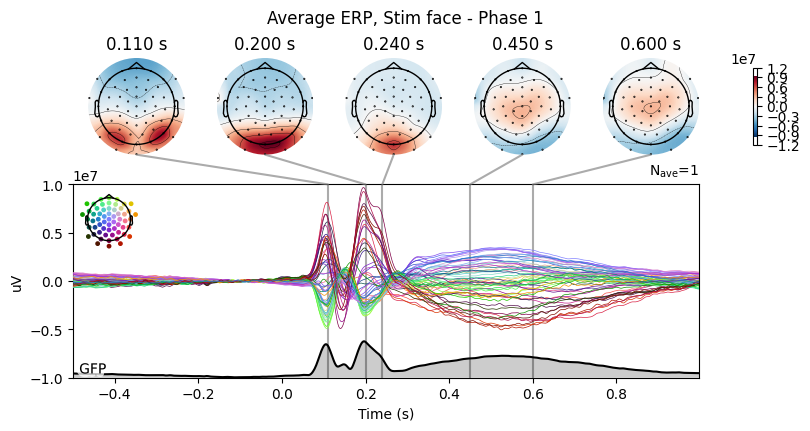

(59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


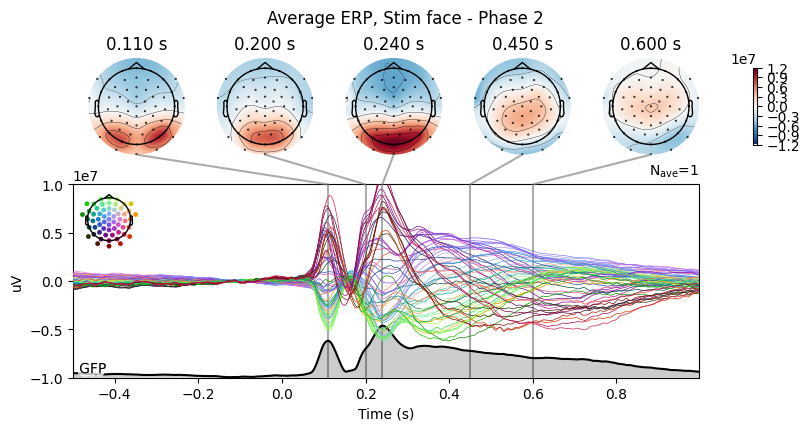

(59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


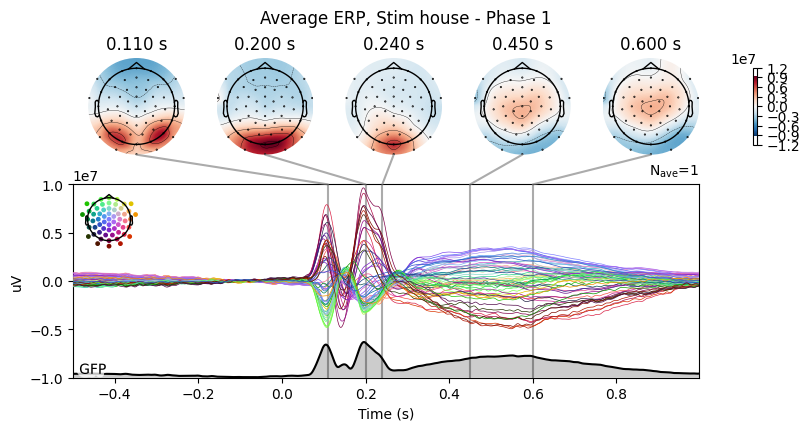

(59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


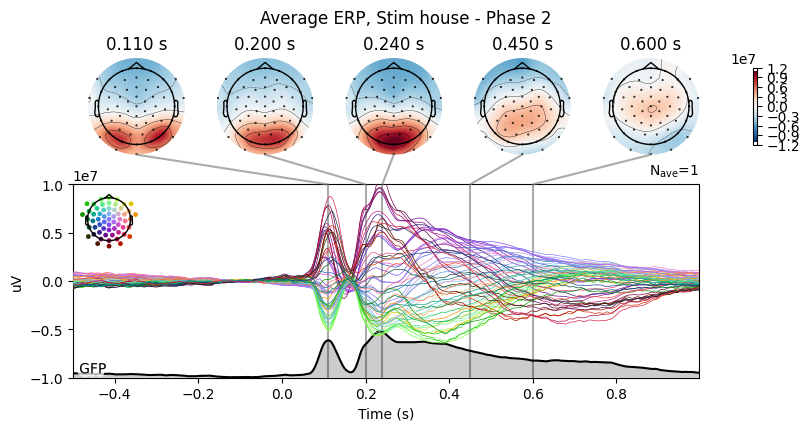

(59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


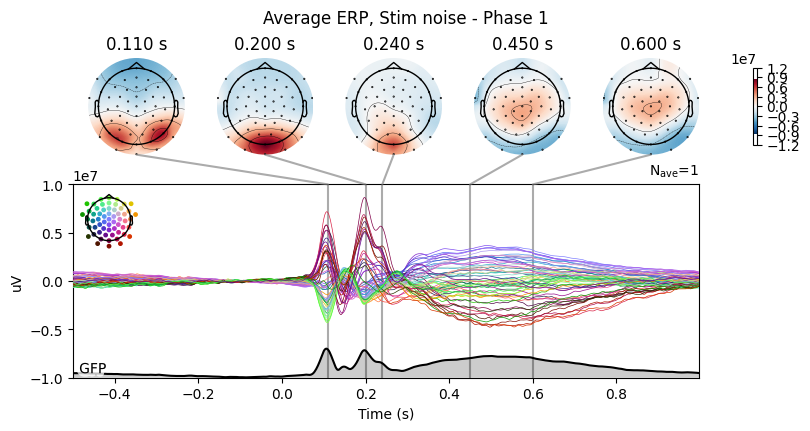

(59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


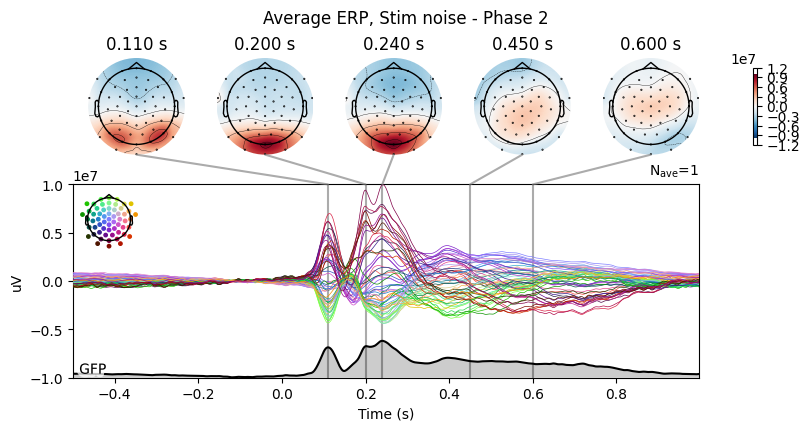

In [22]:
for k, diff in enumerate(all_diffs):
    for i, phases in enumerate(diff):
        if i < 2:

            evoked_data = np.mean(all_diffs[k][i],axis=0)
            print(evoked_data.shape)
            ts_args = dict(gfp =True,units=dict(eeg='uV'),unit=True,ylim=dict(eeg=[-10000000, 10000000]))
            evoked_data = evoked_data[:,0:750]
            evoked = mne.EvokedArray(evoked_data, info, tmin=-0.5)
            #evoked.filter(l_freq=0.5,h_freq=45)
            evoked.plot_joint(times = [0.11,0.2,0.24, .45,.6],ts_args=ts_args,title=f'Average ERP, Stim {stims[k]} - Phase {i+1}')


In [133]:
# FOR WILCOX TESTS
# Parameters
all_diffs = np.array(all_diffs)
n_conditions = all_diffs.shape[1]
n_observations = all_diffs.shape[2]

pval = 0.05
n = n_observations  # Number of paired observations
tail = 2  # Use 1 for one-tailed or 2 for two-tailed

# Z-score for the desired p-value
z = stats.norm.ppf(1 - pval / tail)

# Wilcoxon threshold based on the normal approximation
# Mean and standard deviation for the Wilcoxon rank-sum distribution
mean_w = n * (n + 1) / 4
std_w = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)

# Threshold for the Wilcoxon test statistic
thresh_wilcox = mean_w + z * std_w

print(thresh_wilcox)

581.7509426150418


In [134]:
print(all_diffs.shape)

(3, 3, 41, 59, 750)


5.211224728359534
(41, 250, 59)
(41, 250, 59)
stat_fun(H1): min=-16.748888 max=15.112908
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 4999/4999 [00:01<00:00, 3264.23it/s]

Step-down-in-jumps iteration #1 found 3 clusters to exclude from subsequent iterations



100%|██████████| Permuting : 4999/4999 [00:01<00:00, 3620.74it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
[0.0002 0.0002 0.0002]
(59, 250)
(59, 250)
(59, 250)


Stimulus  Cluster ID  Start Time (s)  End Time (s)  P-Value  All T-Values  \
0     face           0           0.116         0.496   0.0002     15.112908   
1     face           1           0.110         0.154   0.0002     15.112908   
2     face           2           0.160         0.494   0.0002     15.112908   

   T-Threshold  Peak Voltage Difference (µV) Channel Peak  Peak Latency  
0     5.211225                      9.513247           P8         0.260  
1     5.211225                      4.120598          PO8         0.134  
2     5.211225                      9.513247           P8         0.260

(3, 41, 59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


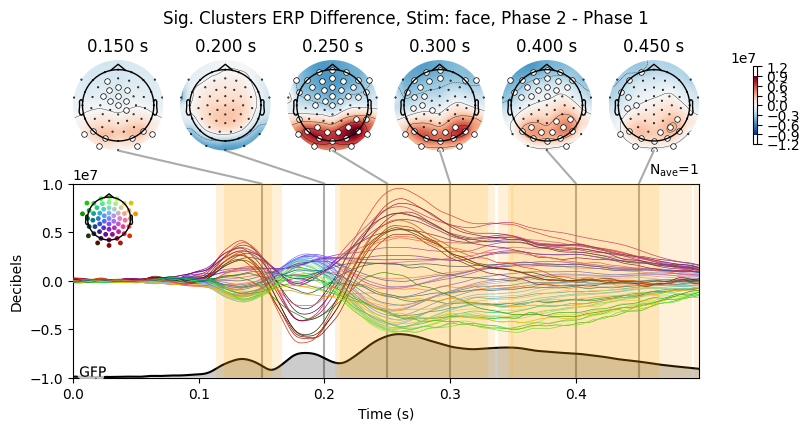

(250, 59)
3
(41, 250, 59)
(41, 250, 59)
stat_fun(H1): min=-16.908188 max=15.021858
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 4999/4999 [00:01<00:00, 3874.35it/s]


Step-down-in-jumps iteration #1 found 4 clusters to exclude from subsequent iterations


100%|██████████| Permuting : 4999/4999 [00:01<00:00, 3760.79it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
[0.0002 0.0002 0.0002 0.0002]
(59, 250)
(59, 250)
(59, 250)
(59, 250)


Stimulus  Cluster ID  Start Time (s)  End Time (s)  P-Value  All T-Values  \
0    house           0           0.114         0.158   0.0002     15.021858   
1    house           1           0.178         0.498   0.0002     15.021858   
2    house           2           0.108         0.158   0.0002     15.021858   
3    house           3           0.174         0.498   0.0002     15.021858   

   T-Threshold  Peak Voltage Difference (µV) Channel Peak  Peak Latency  
0     5.211225                      4.575186           P8         0.140  
1     5.211225                      7.973742           P8         0.284  
2     5.211225                      4.575186           P8         0.140  
3     5.211225                      7.973742           P8         0.284

(3, 41, 59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


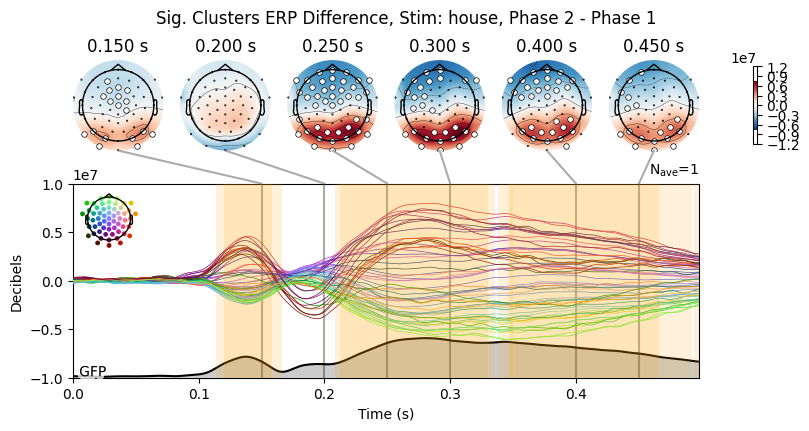

(250, 59)
4
(41, 250, 59)
(41, 250, 59)
stat_fun(H1): min=-10.868900 max=11.941117
Running initial clustering …
Found 8 clusters


100%|██████████| Permuting : 4999/4999 [00:01<00:00, 3671.10it/s]


Step-down-in-jumps iteration #1 found 8 clusters to exclude from subsequent iterations


100%|██████████| Permuting : 4999/4999 [00:01<00:00, 3778.91it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


[0.0002 0.0002 0.0002 0.0036 0.0002 0.0002 0.0002 0.0036]
(59, 250)
(59, 250)
(59, 250)
(59, 250)
(59, 250)
(59, 250)
(59, 250)
(59, 250)


Stimulus  Cluster ID  Start Time (s)  End Time (s)  P-Value  All T-Values  \
0    noise           0           0.120         0.166   0.0002     11.941117   
1    noise           1           0.208         0.336   0.0002     11.941117   
2    noise           2           0.348         0.492   0.0002     11.941117   
3    noise           3           0.494         0.498   0.0036     11.941117   
4    noise           4           0.114         0.158   0.0002     11.941117   
5    noise           5           0.212         0.330   0.0002     11.941117   
6    noise           6           0.338         0.466   0.0002     11.941117   
7    noise           7           0.346         0.350   0.0036     11.941117   

   T-Threshold  Peak Voltage Difference (µV) Channel Peak  Peak Latency  
0     5.211225                      3.244793          PO8         0.138  
1     5.211225                      6.782971          PO8         0.268  
2     5.211225                      3.449539           P8         0.418  
3     5.211225                      2.049075           P8         0.494  
4     5.211225                      3.244793          PO8         0.138  
5     5.211225                      6.782971          PO8         0.268  
6     5.211225                      3.449539           P8         0.418  
7     5.211225                      2.066924          PO8         0.348

(3, 41, 59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


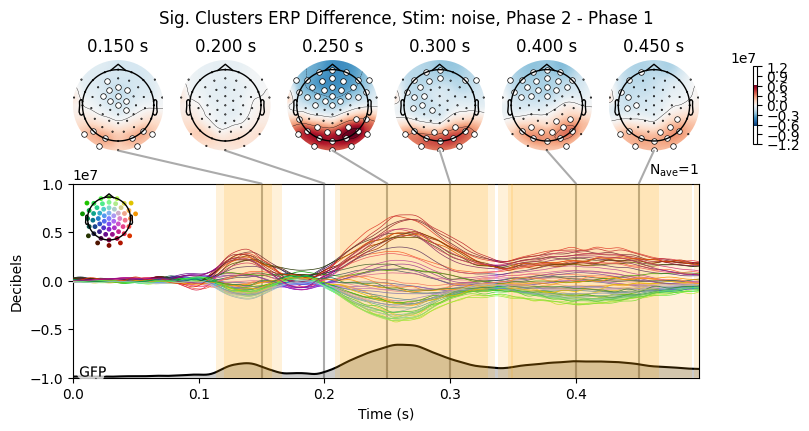

(250, 59)
8


In [135]:
# RUN CLUSTER ANALYSIS
from mne.stats import spatio_temporal_cluster_1samp_test
import scipy.stats
all_diffs = np.array(all_diffs)

n_conditions = all_diffs.shape[1]
n_observations = all_diffs.shape[2]

# FOR F TESTS
pval = 0.01  # arbitrary
dfn = n_conditions - 1  # degrees of freedom numerator
dfd = n_observations - n_conditions  # degrees of freedom denominator
thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution
print(thresh)

#thresh = 2

threshold_tfce = dict(start=0, step=0.2)

stims = ['face','house','noise']
all_cluster_data = []

all_summaries = []
for i, diff in enumerate(all_diffs):
    plot_times = []
    summary_data = []
    data1 = np.array(diff[0])
    data2 = np.array(diff[1])

    # Define Variables
    start_time = 0
    time0 = 250
    time1 = 500

    sig = 0.01

    # Run the cluster-based permutation test
    data1_mean = np.mean(data1,axis=0)

    clu_data1_mean = data1[:,:,time0:time1].transpose(0,2,1)

    print(clu_data1_mean.shape)

    data2_mean = np.mean(data2[:,:,time0:time1],axis=0)

    clu_data2_mean = data2[:,:,time0:time1].transpose(0,2,1)
    print(clu_data2_mean.shape)

    time_adjacency = combine_adjacency(time1-time0,adjacency)

    # T_obs, clusters, cluster_p_values, Ho = spatio_temporal_cluster_test(
    #     [clu_data2_mean, clu_data1_mean], n_permutations=5000, tail=1, n_jobs=-1, buffer_size=None, 
    #     out_type='mask',adjacency=adjacency,max_step=1,threshold=thresh)#,stat_fun=wilcoxon_stat_fun)
    
    T_obs, clusters, cluster_p_values, Ho = spatio_temporal_cluster_1samp_test(
        clu_data2_mean - clu_data1_mean, n_permutations=5000, tail=0, n_jobs=-1, buffer_size=None, 
        out_type='mask',adjacency=adjacency,max_step=1,threshold=thresh,step_down_p=0.01,seed=2024)#_wilcox,stat_fun=wilcoxon_stat_fun)
    
    cluster_data = {'T_obs':T_obs,'clusters':clusters,'cluster_p_values':cluster_p_values,'H0':Ho}
    print(cluster_data['cluster_p_values'])
    
    for i_c, c in enumerate(cluster_data['clusters']):
        
        if cluster_data['cluster_p_values'][i_c] <= sig:
            
            #significant_mask[c] = True
            first_index, last_index = find_first_last_true(c)

            # Calculate beginning, middle, and end for the highlighted region
            start_time = first_index * 2 / 1000
            end_time = last_index * 2 / 1000
            middle_time = (start_time + end_time) / 2

            # Option 1: 25th and 75th percentiles
            start_time2 = start_time + 0.25 * (end_time - start_time)  # 25% into the highlighted region
            end_time2 = start_time + 0.75 * (end_time - start_time)    # 75% into the highlighted region
            middle_time2 = (start_time + end_time) / 2                 # Middle point between 25th and 75th percentiles

            # Append the times to be plotted
            plot_times.extend([start_time2, middle_time2, end_time2])
            # to plot the table
            this_data = np.mean(diff[1],axis=0) - np.mean(diff[0],axis=0)
            this_data = this_data[:,time0:time1]
            print(this_data.shape)
            max_peak = np.max(this_data[:,first_index:last_index])
            min_peak = np.min(this_data[:,first_index:last_index])
            peak = max_peak if np.abs(max_peak) >= np.abs(min_peak) else min_peak
            chan_peak = np.where(this_data==peak)
            summary_data.append({
                'Stimulus': stims[i],
                'Cluster ID': i_c,
                'Start Time (s)': start_time,
                'End Time (s)': end_time,
                'P-Value': cluster_data['cluster_p_values'][i_c],
                'All T-Values': np.max(cluster_data['T_obs']),  # Store all t-values in a list
                'T-Threshold': thresh,
                'Peak Voltage Difference (µV)': peak,
                'Channel Peak': nearest_10_20_names[chan_peak[0][0]],
                'Peak Latency': chan_peak[1][0]* 2 / 1000,
            })
            df = pd.DataFrame(summary_data)
            
            all_summaries.append(summary_data)
    display(df)

    mask = significant_mask[:,:]
    topomap_args = {'mask':mask.T,'mask_params':mask_params}
    ts_args = dict(gfp=True,highlight=highlights,units=dict(eeg='Decibels'),unit=True,ylim=dict(eeg=[-10000000, 10000000]))
    #ts_args = dict(times=[.0194,.250,.304,.325,.350])
    times = [.09,.134,.22,.45]
    times2 = [.15,.2,.25,.3,.4,.45]
    print(diff.shape)
 
    evoked_data = np.mean(diff[1] - diff[0],axis=0) #- np.mean(all_diffs[2][1] - all_diffs[2][0],axis=0)
    #evoked_data = clu_data2_mean - clu_data1_mean
    evoked_data = evoked_data[:,time0:time1]
    evoked = mne.EvokedArray(evoked_data, info, tmin=true_time0)
    #evoked.plot_joint(times=times2,title=f'Average ERP accross participants, {stims[i]} Phase 2 - phase 1')
                      
    fig = evoked.plot_joint(times=times2,topomap_args= topomap_args,ts_args=ts_args,title=f'Sig. Clusters ERP Difference, Stim: {stims[i]}, Phase 2 - Phase 1')

    all_cluster_data.append(cluster_data)

    print(T_obs.shape)
    print(len(clusters))
    with open(f'Cluster_Analysis_phase1Vsphase2_{stims[i]}_nonoise.pkl', 'wb') as f:
        pickle.dump((cluster_data), f)

with open(f'All_IB_Cluster_Analysis_phase1Vsphase2_{stims[i]}_nonoise.pkl', 'wb') as f:
        pickle.dump((all_cluster_data), f)

In [66]:
# OPENS UP THE DATASET

# stim = 'house'

# diff = []
# with open(f'Data_Phase1VsPhase2_{stim}_minus_noise.pkl', 'rb') as f:
#     (diff) = pickle.load(f)

In [67]:
np.array(all_diffs).shape

(3, 3, 41, 59, 750)

In [68]:
all_cluster_data[2]['cluster_p_values']

array([7.636e-01, 7.858e-01, 7.032e-01, 5.996e-01, 2.000e-04, 7.856e-01,
       7.104e-01, 5.590e-01, 2.212e-01, 4.000e-04, 5.154e-01, 2.000e-04])

0.0
0.5
(250, 59)
(59, 250)
0.26
(59, 250)
0.134
(59, 250)
0.26


Stimulus  Cluster ID  Start Time (s)  End Time (s)  P-Value  Max T-Values  \
0     face           0           0.116         0.496   0.0002     15.112908   
1     face           1           0.110         0.154   0.0002     15.112908   
2     face           2           0.160         0.494   0.0002     15.112908   

   T-Threshold  Peak Voltage Difference (µV) Channel Peak  Peak Latency  
0     5.211225                      9.513247           P8         0.260  
1     5.211225                      4.120598          PO8         0.134  
2     5.211225                      9.513247           P8         0.260

(3, 41, 59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


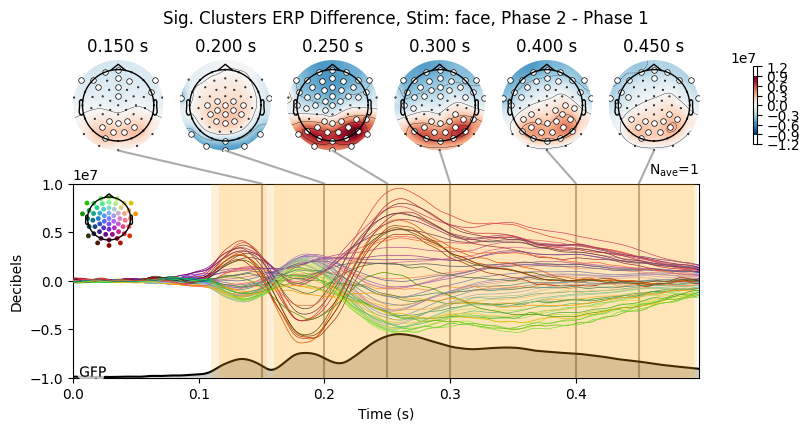

(250, 59)
(59, 250)
0.14
(59, 250)
0.284
(59, 250)
0.14
(59, 250)
0.284


Stimulus  Cluster ID  Start Time (s)  End Time (s)  P-Value  Max T-Values  \
0    house           0           0.114         0.158   0.0002     15.021858   
1    house           1           0.178         0.498   0.0002     15.021858   
2    house           2           0.108         0.158   0.0002     15.021858   
3    house           3           0.174         0.498   0.0002     15.021858   

   T-Threshold  Peak Voltage Difference (µV) Channel Peak  Peak Latency  
0     5.211225                      4.575186           P8         0.140  
1     5.211225                      7.973742           P8         0.284  
2     5.211225                      4.575186           P8         0.140  
3     5.211225                      7.973742           P8         0.284

(3, 41, 59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


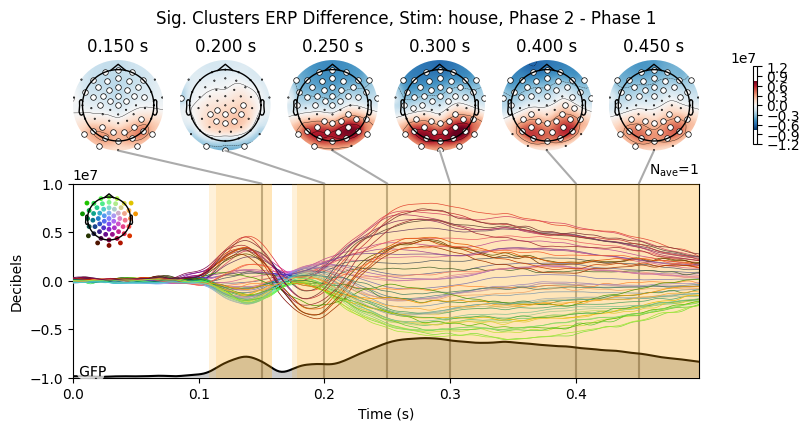

(250, 59)
(59, 250)
0.138
(59, 250)
0.268
(59, 250)
0.418
(59, 250)
0.494
(59, 250)
0.138
(59, 250)
0.268
(59, 250)
0.418
(59, 250)
0.348


Stimulus  Cluster ID  Start Time (s)  End Time (s)  P-Value  Max T-Values  \
0    noise           0           0.120         0.166   0.0002     11.941117   
1    noise           1           0.208         0.336   0.0002     11.941117   
2    noise           2           0.348         0.492   0.0002     11.941117   
3    noise           3           0.494         0.498   0.0036     11.941117   
4    noise           4           0.114         0.158   0.0002     11.941117   
5    noise           5           0.212         0.330   0.0002     11.941117   
6    noise           6           0.338         0.466   0.0002     11.941117   
7    noise           7           0.346         0.350   0.0036     11.941117   

   T-Threshold  Peak Voltage Difference (µV) Channel Peak  Peak Latency  
0     5.211225                      3.244793          PO8         0.138  
1     5.211225                      6.782971          PO8         0.268  
2     5.211225                      3.449539           P8         0.418  
3     5.211225                      2.049075           P8         0.494  
4     5.211225                      3.244793          PO8         0.138  
5     5.211225                      6.782971          PO8         0.268  
6     5.211225                      3.449539           P8         0.418  
7     5.211225                      2.066924          PO8         0.348

(3, 41, 59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


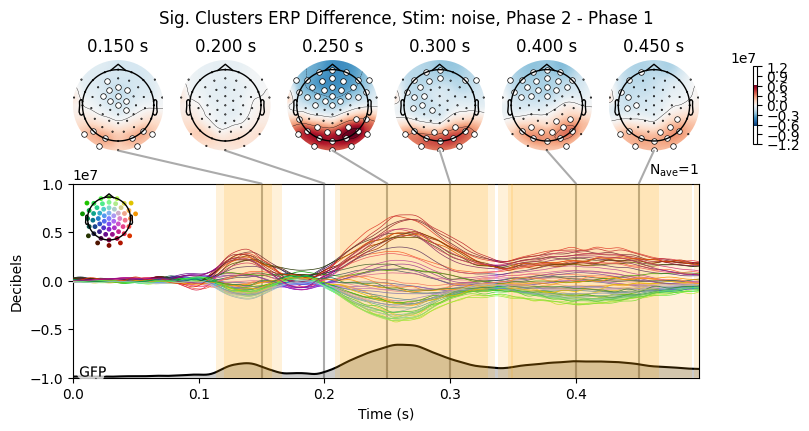

In [119]:

mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=8)
plot_times = [np.arange(i, i+10) for i in range(time0, time1, 10)]

true_time0 = (time0-time0)*2/1000
true_time1 = (time1-time0)*2/1000

print(true_time0)
print(true_time1)

all_diffs = np.array(all_diffs)
all_summaries = []
for i, diff in enumerate(all_diffs):
    # Collect Significant mask if any
    summary_data = []
    plot_times = []
    times = np.arange(data1.shape[1]) / sfreq  # Convert to seconds
    significant_mask = np.zeros_like(all_cluster_data[i]['T_obs'], dtype=bool)
    print(significant_mask.shape)
    count = 0
    

    highlights = []
    for i_c, c in enumerate(all_cluster_data[i]['clusters']):
        #print(all_cluster_data[i]['cluster_p_values'])
        
        if all_cluster_data[i]['cluster_p_values'][i_c] <= 0.01:
            first_index, last_index = find_first_last_true(c)
            #print(first_index,last_index)

            highlights.append([(first_index)*2/1000,(last_index)*2/1000])
            #print(highlights)
            significant_mask[c] = True

            # Calculate beginning, middle, and end for the highlighted region
            start_time = first_index * 2 / 1000
            end_time = last_index * 2 / 1000
            middle_time = (start_time + end_time) / 2

            # Option 1: 25th and 75th percentiles
            start_time2 = start_time + 0.25 * (end_time - start_time)  # 25% into the highlighted region
            end_time2 = start_time + 0.75 * (end_time - start_time)    # 75% into the highlighted region
            middle_time2 = (start_time + end_time) / 2                 # Middle point between 25th and 75th percentiles

            # Append the times to be plotted
            #plot_times.extend([start_time2, middle_time2, end_time2])
            #plot_times.extend([middle_time2])
            # to plot the table
            this_data = np.mean(diff[1],axis=0) - np.mean(diff[0],axis=0)
            this_data = this_data[:,time0:time1]
            print(this_data.shape)
            max_peak = np.max(this_data[:,first_index:last_index])
            min_peak = np.min(this_data[:,first_index:last_index])
            peak = max_peak if np.abs(max_peak) >= np.abs(min_peak) else min_peak
            chan_peak = np.where(this_data==peak)
            print(chan_peak[1][0]* 2 / 1000)

            plot_times.extend([chan_peak[1][0]* 2 / 1000])
            summary_data.append({
                'Stimulus': stims[i],
                'Cluster ID': i_c,
                'Start Time (s)': start_time,
                'End Time (s)': end_time,
                'P-Value': all_cluster_data[i]['cluster_p_values'][i_c],
                'Max T-Values': np.max(all_cluster_data[i]['T_obs']),  # Store all t-values in a list
                'T-Threshold': thresh,
                'Peak Voltage Difference (µV)': peak,
                'Channel Peak': nearest_10_20_names[chan_peak[0][0]],
                'Peak Latency': chan_peak[1][0]* 2 / 1000,
            })
            df = pd.DataFrame(summary_data)
            
            all_summaries.append(summary_data)
    display(df)

    mask = significant_mask[:,:]
    topomap_args = {'mask':mask.T,'mask_params':mask_params}
    ts_args = dict(gfp=True,highlight=highlights,units=dict(eeg='Decibels'),unit=True,ylim=dict(eeg=[-10000000, 10000000]))
    #ts_args = dict(times=[.0194,.250,.304,.325,.350])
    times = [.09,.134,.22,.45]
    times2 = [.15,.2,.25,.3,.4,.45]
    print(diff.shape)
 
    evoked_data = np.mean(diff[1] - diff[0],axis=0) #- np.mean(all_diffs[2][1] - all_diffs[2][0],axis=0)
    evoked_data = evoked_data[:,time0:time1]
    evoked = mne.EvokedArray(evoked_data, info, tmin=true_time0)
    #evoked.plot_joint(times=times2,title=f'Average ERP accross participants, {stims[i]} Phase 2 - phase 1')
                      
    fig = evoked.plot_joint(times=times2,topomap_args= topomap_args,ts_args=ts_args,title=f'Sig. Clusters ERP Difference, Stim: {stims[i]}, Phase 2 - Phase 1')


Frequency Analysis

In [70]:
# CREATE DATASET, PICKLES



stims = ['face','house','noise']

time_freq = True
textTF = ''
all_diffs_TF = []
for k, stim in enumerate(stims):
    diff_TF = []
    for j, label in enumerate(np.unique(all_data.phase)):
        full_erp = []
        erps = []
        for i in np.unique(all_data.subject_id):
            print('Running participant',i)
            
            vis_mask = all_data.phase == label
            stim_mask = all_data.stimulus == stim
            groups_mask = all_data.groups == 1
            subject_mask = all_data.subject_id == i
            final_mask = subject_mask * stim_mask * vis_mask * groups_mask
        
            this_data = all_data.data[:,:,final_mask]
            this_data = this_data[chan_mask,:,:]

            #noise_mask = all_data.stimulus == 'noise'
            
            #final_noise_mask = subject_mask * noise_mask * vis_mask
            #noise_data = all_data.data[:,:,final_noise_mask]
            #noise_data = noise_data[chan_mask,:,:]

            #print(this_data.shape)
            #print(noise_data.shape)
            #plt.plot(np.mean(this_data, axis=2).T)
            this_data = average_reference(this_data)
            #noise_data = average_reference(noise_data)
            #plt.plot(np.mean(this_data, axis=2).T)
            #this_data = remove_baseline(this_data,400,500)
            #noise_data = remove_baseline(noise_data,400,500)

            this_data = this_data.transpose(2,0,1)
            #noise_data = noise_data.transpose(2,0,1)
            print(this_data.shape)

            if time_freq:
                this_data = make_time_frequency(this_data,[2,50])
                #noise_data = make_time_frequency(noise_data,[2,50])
                print('TF transformed data Shape',this_data.shape)
            
            this_data = np.mean(this_data, axis=0)
            #noise_data = np.mean(noise_data, axis=0)

            print(this_data.shape)

            #print('Final Data Shape',this_data.shape)
            #print(noise_data.shape)
            #plt.plot(np.mean(this_data, axis=2).T)
            #erp = np.mean(this_data, axis=2) - np.mean(noise_data, axis=2)

            #full_erp.append(average_reference(this_data))
            this_erp = this_data #- noise_data
            erps.append(this_erp)
        diff_TF.append(erps)
    all_diffs_TF.append(diff)

    if time_freq:
        textTF = 'TF_'

    with open(f'{textTF}Data_Phase1VsPhase2_{stim}.pkl', 'wb') as f:
        pickle.dump(diff, f)

    # this_data2 = np.array(diff[j])
    # print(this_data2.shape)
    # fig = plt.plot(np.arange(-1000,1500,2),this_data2[:,1,:].T)
    # plt.title(f'Average ERP (Fz), {stim}, phase {label}')
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Amplitude')
    # plt.tight_layout()
    # #this_data2 = this_data2[:,:]
    # print(this_data2.shape)
    # plt.figure(figsize=(10, 5))
    # plt.subplot(3, 1, 1)
    # print(np.array(diff[j]).shape)
    # fig = plt.plot(np.arange(-1000,1500,2),np.mean(this_data2,axis = 0).T)
    # plt.title(f'Average ERP, {stim}, phase {label}')
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Amplitude')
    # plt.tight_layout()
    # plt.show()
    
    

Running participant 1
(191, 59, 750)
Computing Time-Frequency


KeyboardInterrupt: 

In [ ]:
from mne.stats import spatio_temporal_cluster_1samp_test
import scipy.stats
all_diffs_TF = np.array(all_diffs_TF)

n_conditions = all_diffs.shape[1]
n_observations = all_diffs.shape[2]

# FOR F TESTS
pval = 0.05  # arbitrary
dfn = n_conditions - 1  # degrees of freedom numerator
dfd = n_observations - n_conditions  # degrees of freedom denominator
thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution
print(thresh)

threshold_tfce = dict(start=0, step=0.2)

stims = ['face','house','noise']
all_cluster_data = []

all_summaries = []
for i, diff in enumerate(all_diffs_TF):
    plot_times = []
    summary_data = []
    data1 = np.array(diff[0])
    data2 = np.array(diff[1])

    # Define Variables
    start_time = 200
    time0 = 500
    time1 = 750

    sig = 0.05

    # Run the cluster-based permutation test
    data1_mean = np.mean(data1,axis=0)
    clu_data1_mean = data1[:,:,:,time0:time1].transpose(0,3,2,1)
    print(clu_data1_mean.shape)

    data2_mean = np.mean(data2[:,:,time0:time1],axis=0)
    clu_data2_mean = data2[:,:,:,time0:time1].transpose(0,3,2,1)
    print(clu_data2_mean.shape)

    time_adjacency = combine_adjacency(time1-time0,adjacency)

    # T_obs, clusters, cluster_p_values, Ho = spatio_temporal_cluster_test(
    #     [clu_data2_mean, clu_data1_mean], n_permutations=5000, tail=1, n_jobs=-1, buffer_size=None, 
    #     out_type='mask',adjacency=adjacency,max_step=1,threshold=thresh)#,stat_fun=wilcoxon_stat_fun)
    
    T_obs, clusters, cluster_p_values, Ho = spatio_temporal_cluster_1samp_test(
        clu_data2_mean - clu_data1_mean, n_permutations=5000, tail=0, n_jobs=1, buffer_size=None, 
        out_type='mask',adjacency=adjacency,max_step=1,threshold=thresh)#_wilcox,stat_fun=wilcoxon_stat_fun)
    
    cluster_data = {'T_obs':T_obs,'clusters':clusters,'cluster_p_values':cluster_p_values,'H0':Ho}
    print(cluster_data['cluster_p_values'])
    

NameError: name 'all_diffs_TF' is not defined

(250, 59)
(3, 41, 59, 750)
No projector specified for this dataset. Please consider the method self.add_proj.


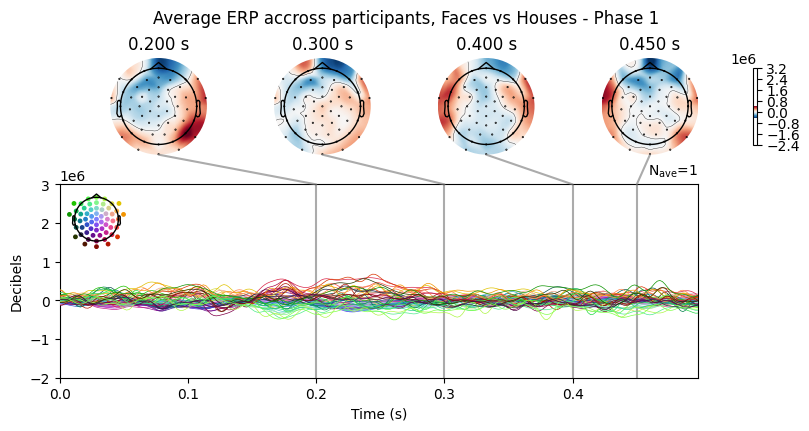

No projector specified for this dataset. Please consider the method self.add_proj.


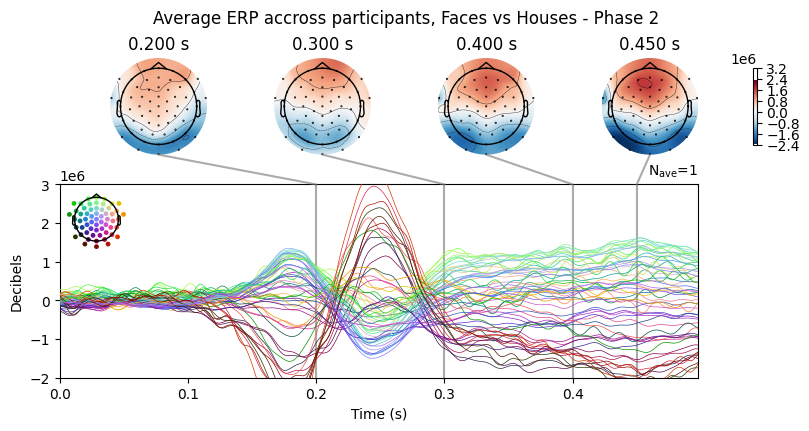

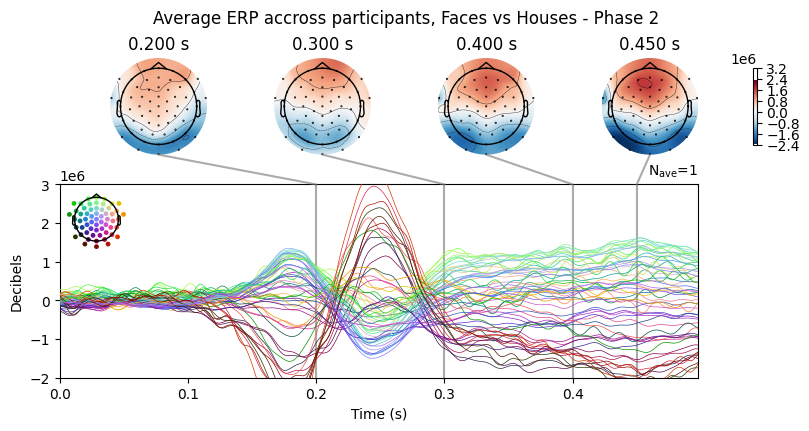

In [ ]:

mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=8)
plot_times = [np.arange(i, i+10) for i in range(time0, time1, 10)]

true_time0 = (time0 - time0)*2/1000
true_time1 = (time1 - time0)*2/1000
all_diffs = np.array(all_diffs)
all_summaries = []
#for i, diff in enumerate(all_diffs):

# Collect Significant mask if any
summary_data = []
plot_times = []
times = np.arange(data1.shape[1]) / sfreq  # Convert to seconds
significant_mask = np.zeros_like(all_cluster_data[i]['T_obs'], dtype=bool)
print(significant_mask.shape)
count = 0

mask = significant_mask[:,:]
topomap_args = {'mask':mask.T,'mask_params':mask_params}
ts_args = dict(units=dict(eeg='Decibels'),unit=True,ylim=dict(eeg=[-2000000, 3000000]))
#ts_args = dict(times=[.0194,.250,.304,.325,.350])
times = [.09,.134,.22,.45]
times2 = [.2,.3,.4,.45]
print(diff.shape)

evoked_data = np.mean(all_diffs[0][0] - all_diffs[1][0],axis=0)
evoked_data = evoked_data[:,time0:time1]
evoked = mne.EvokedArray(evoked_data, info, tmin=true_time0)
evoked.plot_joint(times = times2,title=f'Average ERP accross participants, Faces vs Houses - Phase 1',ts_args=ts_args)

evoked_data = np.mean(all_diffs[0][1] - all_diffs[1][1],axis=0)
evoked_data = evoked_data[:,time0:time1]
evoked = mne.EvokedArray(evoked_data, info, tmin=true_time0)
evoked.plot_joint(times = times2,title=f'Average ERP accross participants, Faces vs Houses - Phase 2',ts_args=ts_args)


In [13]:
# PLOT ERP FOR EVERY PARTICIPANT FOR EVERY STIMULUS

time0 = 250
time1 = 750

mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=8)
plot_times = [np.arange(i, i+10) for i in range(time0, time1, 10)]



true_time0 = (time0 - time0)*2/1000
true_time1 = (time1 - time0)*2/1000
all_diffs = np.array(all_diffs)
all_summaries = []
for i, diff in enumerate(all_diffs):
    # Collect Significant mask if any
    summary_data = []
    plot_times = []
    times = np.arange(data1.shape[1]) / sfreq  # Convert to seconds
    significant_mask = np.zeros_like(all_cluster_data[i]['T_obs'], dtype=bool)
    print(significant_mask.shape)
    count = 0
    
    mask = significant_mask[:,:]
    topomap_args = {'mask':mask.T,'mask_params':mask_params}
    ts_args = dict(unit=True,ylim=dict(eeg=[-10000000, 10000000]))
    #ts_args = dict(times=[.0194,.250,.304,.325,.350])
    times = [.09,.134,.22,.45]
    times2 = [.2,.25,.3,.4]
    print(diff.shape)
    #for k, phases in enumerate(diff):
    for j, sub in enumerate(diff[0]):

        evoked_data = diff[1][j] - diff[0][j]
        evoked_data = evoked_data[:,time0:time1]
        evoked = mne.EvokedArray(evoked_data, info, tmin=true_time0)
        evoked.plot_joint(times = times2,title=f'Avg. ERP for Subj. {np.unique(all_data.subject_id)[j]} Phase 2 - Phase 1 {stims[i]}',ts_args=ts_args)
    


NameError: name 'all_diffs' is not defined

In [ ]:


mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=8)
plot_times = [np.arange(i, i+10) for i in range(time0, time1, 10)]

true_time0 = (time0 - 500)*2/1000
true_time1 = (time1 - 500)*2/1000
all_diffs = np.array(all_diffs)
all_summaries = []
for i, diff in enumerate(all_diffs):
    # Collect Significant mask if any
    summary_data = []
    plot_times = []
    times = np.arange(data1.shape[1]) / sfreq  # Convert to seconds
    significant_mask = np.zeros_like(all_cluster_data[i]['T_obs'], dtype=bool)
    print(significant_mask.shape)
    count = 0
    
    mask = significant_mask[:,:]
    topomap_args = {'mask':mask.T,'mask_params':mask_params}
    ts_args = dict(unit=True,ylim=dict(eeg=[-10000000, 10000000]))
    #ts_args = dict(times=[.0194,.250,.304,.325,.350])
    times = [.09,.134,.22,.45]
    times2 = [.2,.3,.4,.45]
    print(diff.shape)
    #for k, phases in enumerate(diff):
    for j, sub in enumerate(diff[0]):

        evoked_data = diff[1][j] - diff[0][j]
        evoked_data = evoked_data[:,time0:time1]
        evoked = mne.EvokedArray(evoked_data, info, tmin=true_time0)
        evoked.plot_joint(times = times,title=f'Avg. ERP for Subj. {j} Phase {k} {stims[i]}',ts_args=ts_args)
    


In [ ]:
display(pd.DataFrame(summary_data))

Empty DataFrame
Columns: []
Index: []

In [ ]:
import mne
import numpy as np

# Assuming 'channel_locations' is a numpy array of shape (n_channels, 3) containing x, y, z positions of your channels
channel_locations = montage
# Load the 10-20 system for comparison
montage_10_20 = mne.channels.make_standard_montage('standard_1020')

# Get the positions from your existing montage
ch_positions = montage.get_positions()['ch_pos']

# Find the nearest 10-20 system channel for each of your montage's channels
nearest_10_20_names = []
for ch_name, ch_pos in ch_positions.items():
    distances = [np.linalg.norm(ch_pos - np.array(montage_10_20.get_positions()['ch_pos'][mch_name])) 
                 for mch_name in montage_10_20.ch_names]
    nearest_idx = np.argmin(distances)
    nearest_name = montage_10_20.ch_names[nearest_idx]
    nearest_10_20_names.append((ch_name, nearest_name))

# Output the mapping of your channels to the nearest 10-20 system names
for original_name, nearest_name in nearest_10_20_names:
    print(f"Original channel {original_name} is closest to 10-20 channel {nearest_name}")

Original channel 1 is closest to 10-20 channel Cz
Original channel 2 is closest to 10-20 channel FCz
Original channel 3 is closest to 10-20 channel FC2
Original channel 4 is closest to 10-20 channel C2
Original channel 5 is closest to 10-20 channel CPz
Original channel 6 is closest to 10-20 channel C1
Original channel 7 is closest to 10-20 channel FC1
Original channel 8 is closest to 10-20 channel Fz
Original channel 9 is closest to 10-20 channel F2
Original channel 10 is closest to 10-20 channel FC4
Original channel 11 is closest to 10-20 channel C4
Original channel 12 is closest to 10-20 channel CP4
Original channel 13 is closest to 10-20 channel P2
Original channel 14 is closest to 10-20 channel Pz
Original channel 15 is closest to 10-20 channel P1
Original channel 16 is closest to 10-20 channel CP3
Original channel 17 is closest to 10-20 channel C3
Original channel 18 is closest to 10-20 channel FC3
Original channel 19 is closest to 10-20 channel F1
Original channel 20 is closest t

In [ ]:
# LOAD CLUSTER ANALYSIS
#stim = 'face'
# with open(f'Cluster_Analysis_phase1Vsphase2_{stim} _minus_noise.pkl', 'rb') as f:
#     cluster_data = pickle.load(f)


# T_obs = cluster_data['T_obs']
# clusters = cluster_data['clusters']
# cluster_p_values = cluster_data['cluster_p_values']

print(T_obs.shape)
print(len(clusters))

(500, 59)
14


In [ ]:
all_cluster_data[0]['T_obs'].shape

(500, 59)

In [ ]:
import pandas as pd

def create_cluster_summary_table(clusters, cluster_p_values, T_obs, T_threshold, all_diffs, sfreq=500,stim=stim):
    summary_data = []
    time_resolution = 2 / 1000  # Time resolution in seconds (adjust based on your data)

    for i_c, cluster in enumerate(clusters):
        if cluster_p_values[i_c] <= 0.01:  # Only include significant clusters
            
            # Find the start and end time points of the cluster
            first_time_idx, last_time_idx = find_first_last_true(cluster)
            start_time = first_time_idx * time_resolution
            end_time = last_time_idx * time_resolution
            
            # Get p-value and T-values
            p_val = cluster_p_values[i_c]
            t_vals = T_obs[cluster]  # All t-values within the cluster
            peak_voltage_diff = np.max(all_diffs[i_c])  # Max voltage difference
            print(peak_voltage_diff)
            
            # Add cluster info to summary data
            summary_data.append({
                'Stimulus': stim,
                'Cluster ID': i_c,
                'Start Time (s)': start_time,
                'End Time (s)': end_time,
                'P-Value': p_val,
                'All T-Values': t_vals.tolist(),  # Store all t-values in a list
                'T-Threshold': T_threshold,
                'Peak Voltage Difference (µV)': peak_voltage_diff
            })
    
    # Convert the summary data to a Pandas DataFrame
    df = pd.DataFrame(summary_data)
    print(df)
    
    return df

# Example usage
T_threshold = 1.96  # Replace with your actual T-threshold
summary_df = create_cluster_summary_table(all_cluster_data[i]['clusters'], 
                                          all_cluster_data[i]['cluster_p_values'], 
                                          all_cluster_data[i]['T_obs'], 
                                          T_threshold, 
                                          all_diffs,stim)

# Display the table
print(summary_df)


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


In [ ]:
len(all_cluster_data[i]['clusters'])

14

In [ ]:
# Plot the significant clusters
for i, stim in enumerate(stims):
    times = np.arange(data1.shape[1]) / sfreq  # Convert to seconds
    significant_mask = np.zeros_like(all_cluster_data[i]['T_obs'].shape, dtype=bool)
    count = 0

    highlights = []
    for i_c, c in enumerate(all_cluster_data[i]['clusters']):
        print(all_cluster_data[i]['cluster_p_values'])
        if all_cluster_data[i]['cluster_p_values'][i_c] <= sig:
            first_index, last_index = find_first_last_true(c)
            print(first_index,last_index)

            highlights.append([(first_index)*2/1000,(last_index)*2/1000])
            print(highlights)
            significant_mask[c] = True
            #ax[0].axvspan(np.min(np.where(c)[0]), np.max(np.where(c)[0]), alpha=0.3,color = cmap.colors[count], label=f'Cluster {i_c}')

[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.758 0.825 0.804 0.899 0.765 0.906 0.721 0.674 0.424 0.694 0.85 ]
[0.891 0.931 0.376 0.725 0.645 0.757]
[0.891 0.931 0.376 0.725 0.645 0.757]
[0.891 0.931 0.376 0.725 0.645 0.757]
[0.891 0.931 0.376 0.725 0.645 0.757]
[0.891 0.931 0.376 0.725 0.645 0.757]
[0.891 0.931 0.376 0.725 0.645 0.757]
[0.963]


In [ ]:
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=8)
        
plot_times = [np.arange(i, i+10) for i in range(time0, time1, 10)]

true_time0 = (time0 - 500)*2/1000
true_time1 = (time1 - 500)*2/1000


evoked_data = np.mean(data2,axis=0) - np.mean(data1,axis=0)
evoked_data = evoked_data[:,time0:time1]
evoked = mne.EvokedArray(evoked_data, info, tmin=true_time0)


In [ ]:
import numpy as np

arr = np.array([0, 2, 5, 0, 3, 1])



In [ ]:
true_time0

0.0

No projector specified for this dataset. Please consider the method self.add_proj.


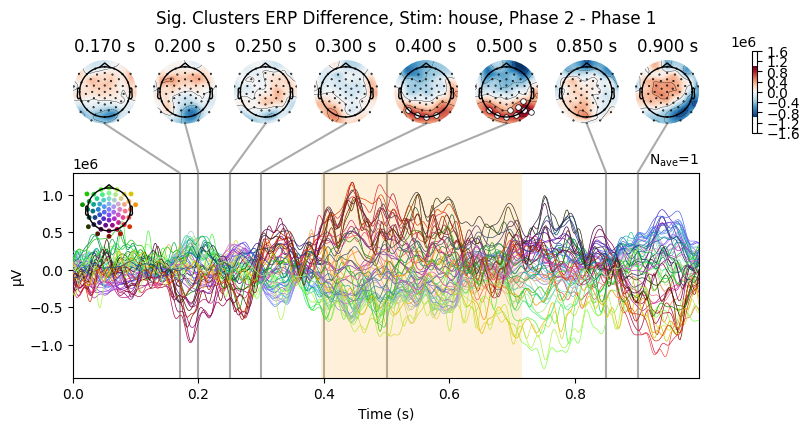

In [ ]:
mask = significant_mask[:,:]


topomap_args = {'mask':mask.T,'mask_params':mask_params}

#fig = evoked.plot_joint(times=np.arange(true_time0, true_time1, 0.10),topomap_args= topomap_args)
#fig1 = evoked.plot()
#fig1.figsize = [10,20]

#fig2 = evoked.plot_topomap()

fig = evoked.plot_joint(times=[0.17,0.2,0.25,0.3,0.4,0.5,0.85,0.9],topomap_args= topomap_args,ts_args=ts_args,title=f'Sig. Clusters ERP Difference, Stim: {stim}, Phase 2 - Phase 1')

#evoked.plot_joint()
#import os

#save_path = os.path.join(os.getcwd(), 'Joint_Plot_ERP_and_Channels_Faces.png')
#fig.set_size_inches(10,6)
#fig.savefig(save_path)

fig.set_size_inches(30, 16)


fig.savefig(f'plot_cluster ERP_sig_mask_{stim}.png', format='png')


In [ ]:
cluster_p_values


array([0.998, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 0.999, 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   , 0.078, 0.022, 1.   , 0.557, 1.   ,
       1.   , 0.286, 1.   , 0.468, 1.   , 1.   , 1.   , 0.099, 1.   ,
       0.33 , 1.   , 1.   , 1.   , 1.   ])

In [ ]:
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [ ]:
fig.figsize = (15,6)


In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mne.viz import plot_topomap

steps = 10

plot_times = [np.arange(i, i+steps) for i in range(time0, time1-steps, steps)]
topomap_data = np.mean(data2[:,:],axis=0) - np.mean(data1[:,:],axis=0)
print(plot_times)


print(topomap_data.shape)

num_of_rows = 2
fig, ax = plt.subplots(num_of_rows, int(len(plot_times)/num_of_rows), figsize=(4*int(len(plot_times)/num_of_rows), 8))
ax = ax.flatten()

for j, time_erp in enumerate(plot_times):
    this_ax = ax[j]
    #print(time_erp)
    this_mask = significant_mask[:,:]
    print(this_mask.shape)
    
    #this_topomap_data = topomap_data[time_erp[0],:]
    this_topomap_data = np.mean(np.take(topomap_data,time_erp,axis=1),axis=1)
    #print(this_topomap_data.shape)
    #mask_params = dict(marker='o', markerfacecolor='r', markeredgecolor='k', linewidth=0, markersize=5,alpha= 0.3)

    im,cm = plot_topomap(this_topomap_data, info, show=False, axes=this_ax, mask=np.take(this_mask,time_erp-time0,axis=0), mask_params=mask_params)
    
    pos = this_ax.get_position()
    time_1 = (time_erp[0])  *2
    time_2 = (np.max(time_erp)) *2
    this_ax.set_title(f'{time_1} to {time_2}',fontsize = 10)
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.005, pos.height*0.9])  # Adjusted relative to topomap
    clb = plt.colorbar(im, cax=cbar_ax)
    clb.ax.set_title(f'T-score',fontsize=6) # title on top of colorbar

plt.show()
fig.savefig(f'Avg Progression over time ERPs {stim}.png', format='png')

[array([500, 501, 502, 503, 504, 505, 506, 507, 508, 509]), array([510, 511, 512, 513, 514, 515, 516, 517, 518, 519]), array([520, 521, 522, 523, 524, 525, 526, 527, 528, 529]), array([530, 531, 532, 533, 534, 535, 536, 537, 538, 539]), array([540, 541, 542, 543, 544, 545, 546, 547, 548, 549]), array([550, 551, 552, 553, 554, 555, 556, 557, 558, 559]), array([560, 561, 562, 563, 564, 565, 566, 567, 568, 569]), array([570, 571, 572, 573, 574, 575, 576, 577, 578, 579]), array([580, 581, 582, 583, 584, 585, 586, 587, 588, 589]), array([590, 591, 592, 593, 594, 595, 596, 597, 598, 599]), array([600, 601, 602, 603, 604, 605, 606, 607, 608, 609]), array([610, 611, 612, 613, 614, 615, 616, 617, 618, 619]), array([620, 621, 622, 623, 624, 625, 626, 627, 628, 629]), array([630, 631, 632, 633, 634, 635, 636, 637, 638, 639]), array([640, 641, 642, 643, 644, 645, 646, 647, 648, 649]), array([650, 651, 652, 653, 654, 655, 656, 657, 658, 659]), array([660, 661, 662, 663, 664, 665, 666, 667, 668, 669

IndexError: index 48 is out of bounds for axis 0 with size 48

In [ ]:
print(significant_mask.shape)

(59, 500)


In [ ]:
seg_data1 = data1[:,:,500:1000]
seg_data2 = data2[:,:,500:1000]
data1.shape

(33, 59, 1250)

In [ ]:
# Load cluster analysis data

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mne.viz import plot_topomap

data1_mean = np.mean(seg_data1,axis=0)
data2_mean = np.mean(seg_data2,axis=0)

plot_data = data2_mean - data1_mean

print(plot_data.shape)

# Set up the figure for plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

cmap = plt.get_cmap('Set1')  # Choose a colormap
norm = Normalize(vmin=times.min(), vmax=times.max())  # Normalize time to [0, 1]

# Create a colormap mappable for the colorbar (optional)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot the significant clusters
times = np.arange(seg_data1.shape[1]) / sfreq  # Convert to seconds
significant_mask = np.zeros_like(T_obs, dtype=bool)
count = 0
for i_c, c in enumerate(clusters):
    if cluster_p_values[i_c] <= 0.05:
        count = count + 1
        significant_mask[c] = True
        ax[0].axvspan(np.min(np.where(c.T)[0]), np.max(np.where(c.T)[0]), alpha=0.3,color = cmap.colors[count], label=f'Cluster {i_c}')

# Plot the ERP difference between conditions
ax[0].plot(np.arange(0,1000,2),data1_mean[44].T - data2_mean[14].T,label = 'ERP Difference')
ax[0].plot(np.arange(0,1000,2),data1_mean[44].T,label = 'ERP Data1')
ax[0].plot(np.arange(0,1000,2),data2_mean[44].T,label = 'ERP Data2')

#plt.fill_between(time_windows, min_cis[i,:,0], max_cis[i,:,1],
#    alpha=0.15, facecolor=clrs[i],label='std. error')
ax[0].set_title(f'Cluster-based Permutation Test Results Chan 8')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('ERP Difference')
ax[0].legend(loc='lower right')
#ax[0].legend(['Significant Cluster'])

# Plot the topography of the first significant cluster
print(significant_mask.shape)
if significant_mask.any():
    mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=5)
    plot_topomap(plot_data, info, show=False, axes=ax[1],
                 mask=significant_mask, mask_params=mask_params)

    ax[1].set_title('Topography of Significant Clusters')

# Save and show the figure
fig.savefig(f'Topography_of_Significant_Clusters_Pz_{stim}.png', format='png')
plt.show()


(59, 500)
(500, 59)


ValueError: Data needs to be array of shape (n_sensors,); got shape (59, 500).

In [ ]:
# with open('Cluster_Analysis_phase1Vsphase2_face _minus_noise.pkl', 'rb') as f:
#     cluster_data = pickle.load(f)

    
T_obs = cluster_data['T_obs']
clusters = cluster_data['clusters']
cluster_p_values = cluster_data['cluster_p_values']

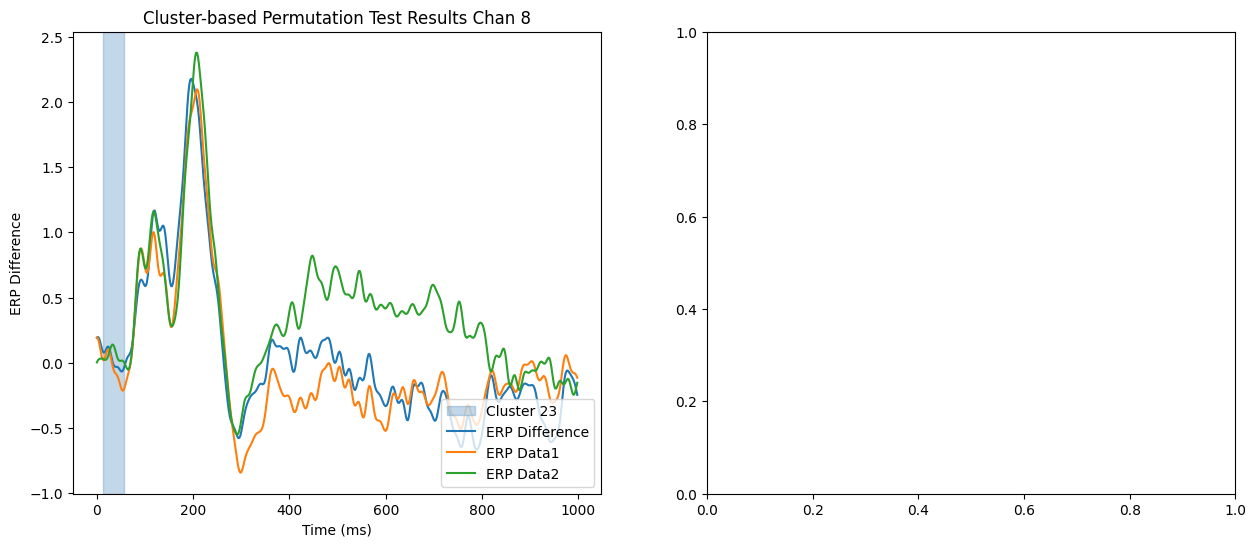

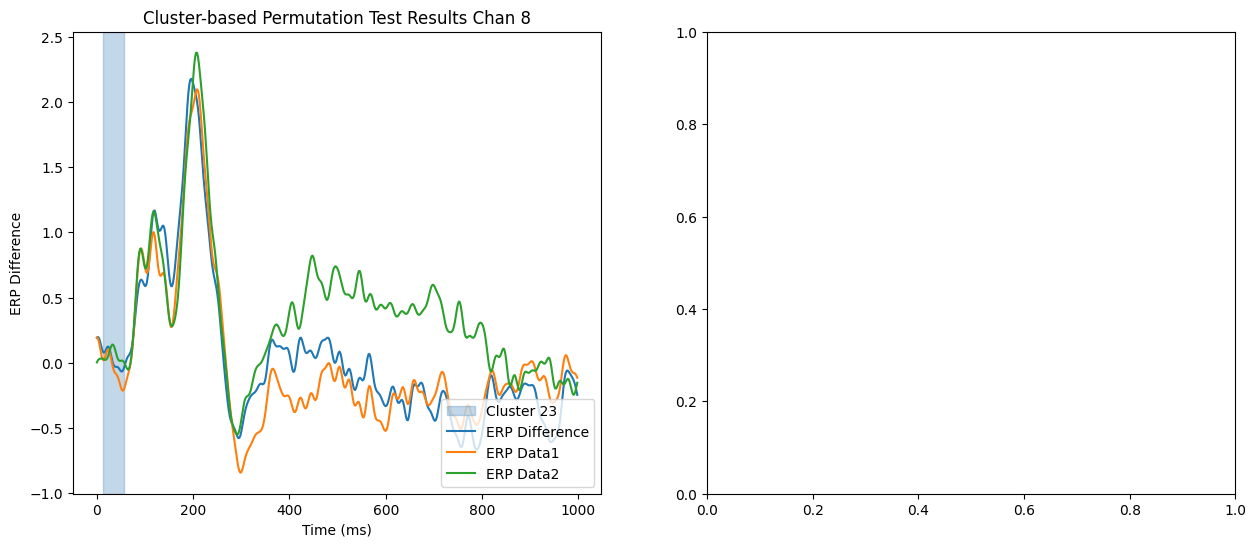

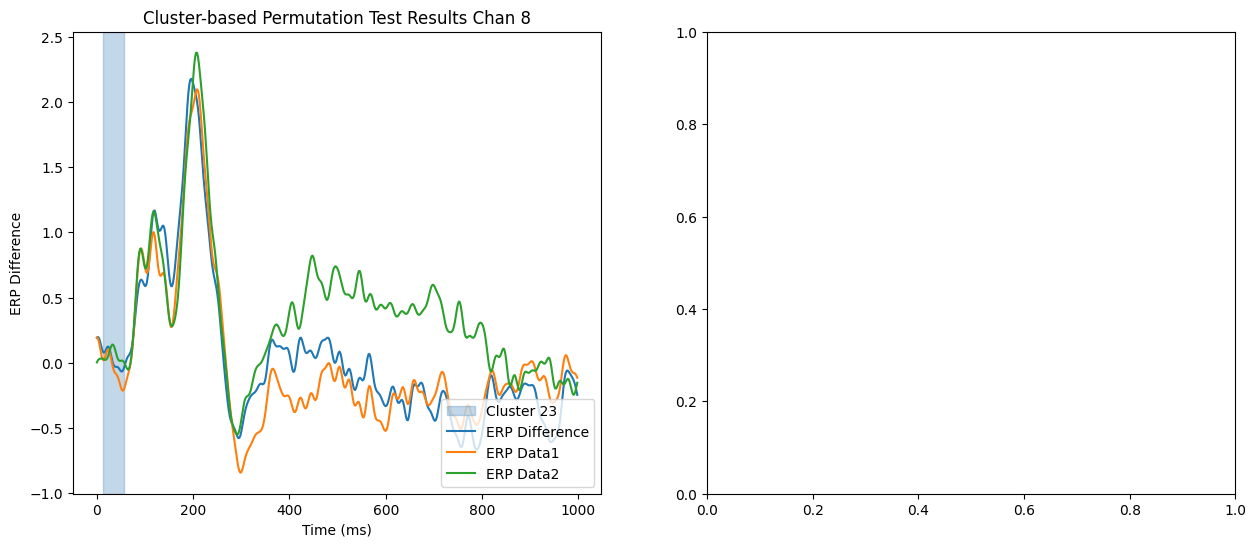

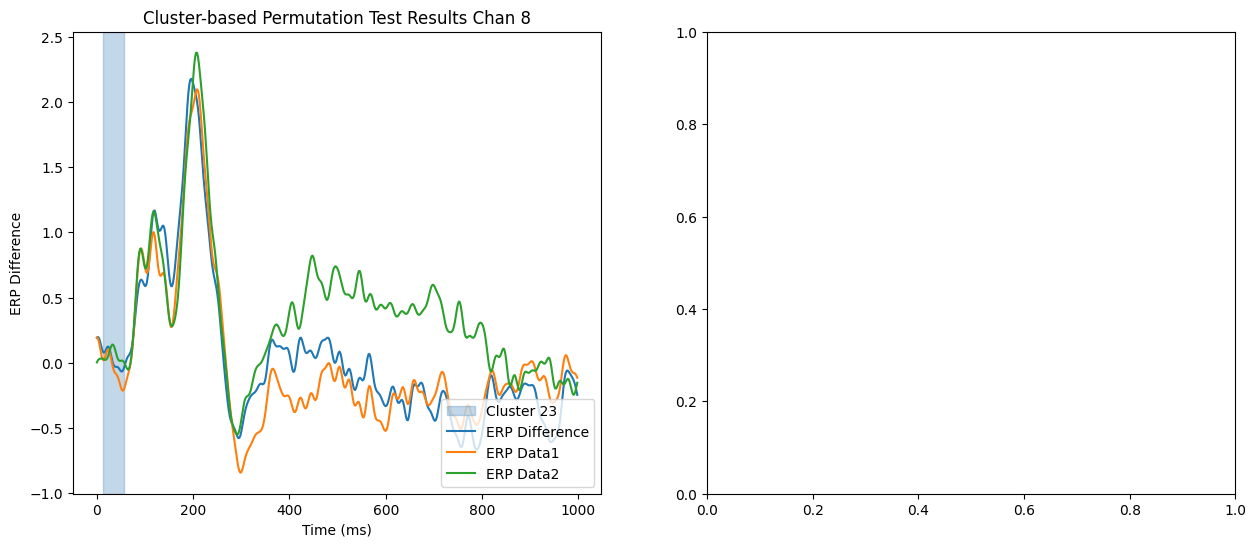

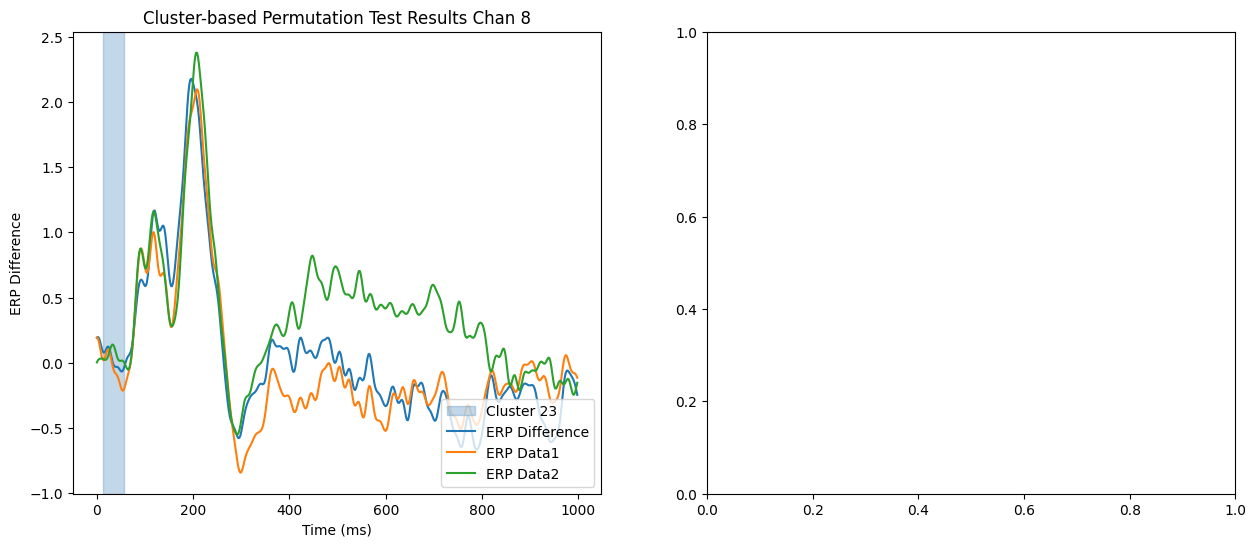

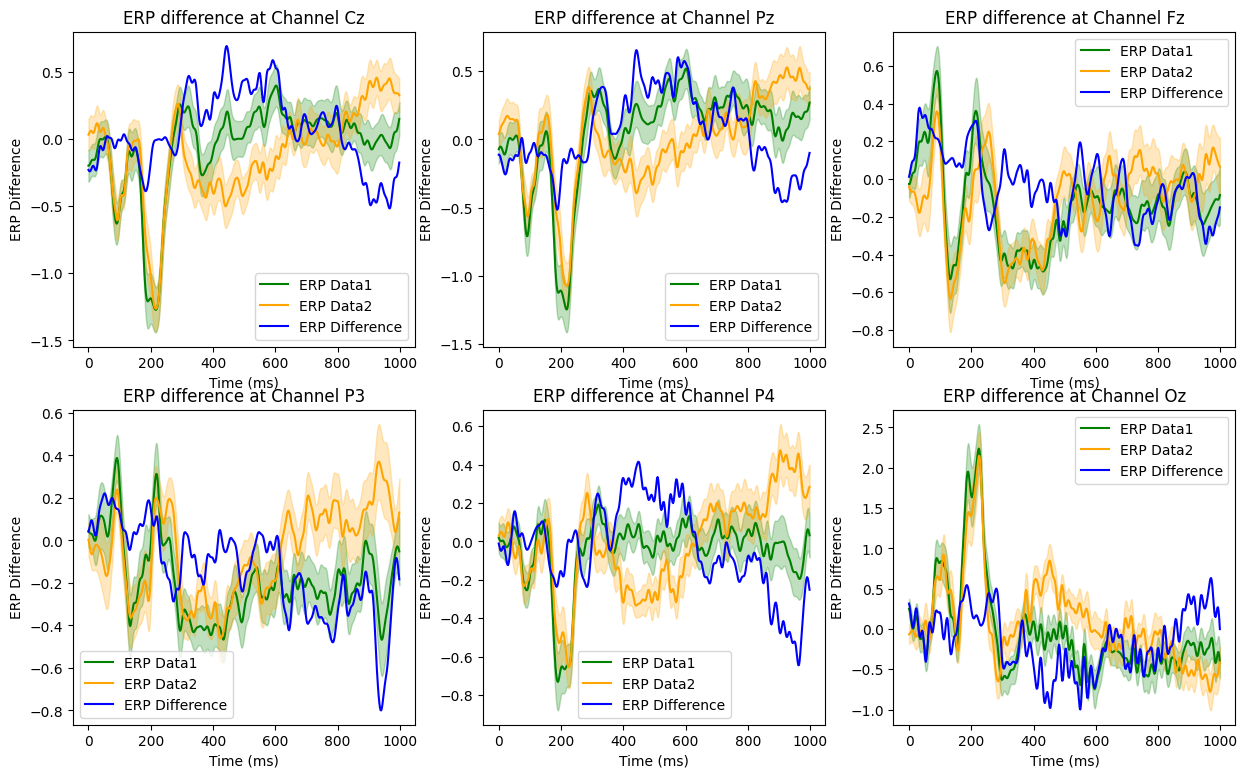

In [ ]:
# Load cluster analysis data

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mne.viz import plot_topomap

this_data1 = seg_data1
this_data2 = seg_data2

data1_mean = np.mean(this_data1,axis=0)
data2_mean = np.mean(this_data2,axis=0)

# Set up the figure for plotting
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
ax = ax.flatten()


times = np.arange(data1.shape[1]) / sfreq  # Convert to seconds
cmap = plt.get_cmap('Set1')  # Choose a colormap
norm = Normalize(vmin=times.min(), vmax=times.max())  # Normalize time to [0, 1]

# Create a colormap mappable for the colorbar (optional)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot the ERP difference between conditions

# choose a number of channels to plot

channels_for_plotting       = [1,14,8,16,12,55]
channels_for_plotting_names = ['Cz','Pz','Fz','P3','P4','Oz']

true_data_length = this_data1.shape[2]*2

adjust_time = 0

clrs = ['b','g','orange']

data1_mean = channel_subselect(data1_mean, channels_for_plotting, False, axis = 0)
data2_mean = channel_subselect(data2_mean, channels_for_plotting, False, axis = 0)

std_errors1 = np.std(this_data1, axis=0) / np.sqrt(this_data1.shape[0]) 
std_errors2 = np.std(this_data1, axis=0) / np.sqrt(this_data1.shape[0]) 

# std_errors1 = np.std(data1, axis=2) / np.sqrt(data1.shape[2]) 
# std_errors2 = np.std(data2, axis=2) / np.sqrt(data2.shape[2]) 

std_errors1 = channel_subselect(std_errors1, channels_for_plotting, False, axis = 0)
std_errors2 = channel_subselect(std_errors2, channels_for_plotting, False, axis = 0)

for chan, i in enumerate(range(data1_mean.shape[0])):
    this_ax = ax[i]
    # this_ax.plot(np.arange(-adjust_time,true_data_length-adjust_time,2),data1_mean[i].T - data2_mean[i].T,label = 'ERP Difference')
    # this_ax.plot(np.arange(-adjust_time,true_data_length-adjust_time,2),data1_mean[i].T,label = 'ERP Data1')
    # up_ci = data1_mean[i] + std_errors1[i]
    # down_ci = data1_mean[i] - std_errors1[i]
    # this_ax.fill_between(np.arange(-adjust_time,true_data_length-adjust_time,2),up_ci.T, down_ci.T,alpha=0.5)
    # this_ax.plot(np.arange(-adjust_time,true_data_length-adjust_time,2),data2_mean[i].T,label = 'ERP Data2')
    # up_ci = data2_mean[i] + std_errors2[i]
    # down_ci = data2_mean[i] - std_errors2[i]
    # this_ax.fill_between(np.arange(-adjust_time,true_data_length-adjust_time,2),up_ci.T, down_ci.T,alpha=0.5)

    
    this_ax.plot(np.arange(-adjust_time,true_data_length-adjust_time,2),data1_mean[i].T,label = 'ERP Data1',color=clrs[1])
    up_ci = data1_mean[i] + std_errors1[i]
    down_ci = data1_mean[i] - std_errors1[i]
    this_ax.fill_between(np.arange(-adjust_time,true_data_length-adjust_time,2),up_ci.T, down_ci.T,alpha=0.25,color=clrs[1])
    this_ax.plot(np.arange(-adjust_time,true_data_length-adjust_time,2),data2_mean[i].T,label = 'ERP Data2',color=clrs[2])
    up_ci = data2_mean[i] + std_errors2[i]
    down_ci = data2_mean[i] - std_errors2[i]
    this_ax.fill_between(np.arange(-adjust_time,true_data_length-adjust_time,2),up_ci.T, down_ci.T,alpha=0.25,color=clrs[2])
    this_ax.plot(np.arange(-adjust_time,true_data_length-adjust_time,2),data1_mean[i].T - data2_mean[i].T,label = 'ERP Difference',color=clrs[0])


#plt.fill_between(time_windows, min_cis[i,:,0], max_cis[i,:,1],
#    alpha=0.15, facecolor=clrs[i],label='std. error')
    this_ax.set_title(f'ERP difference at Channel {channels_for_plotting_names[i]}')
    this_ax.set_xlabel('Time (ms)')
    this_ax.set_ylabel('ERP Difference')
    this_ax.legend(loc='best')

fig.savefig(f'Channel ERPs {stim}.png', format='png')
plt.show()


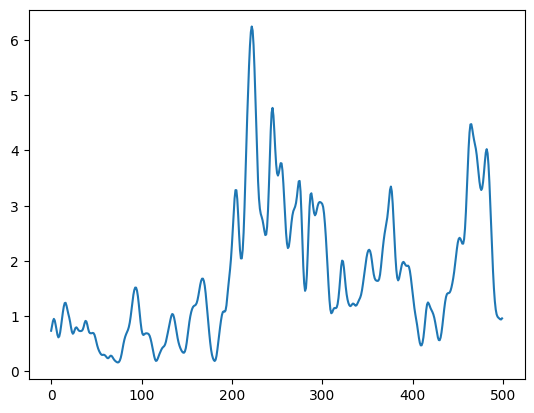

In [ ]:
plt.plot(np.mean(T_obs,axis=0))

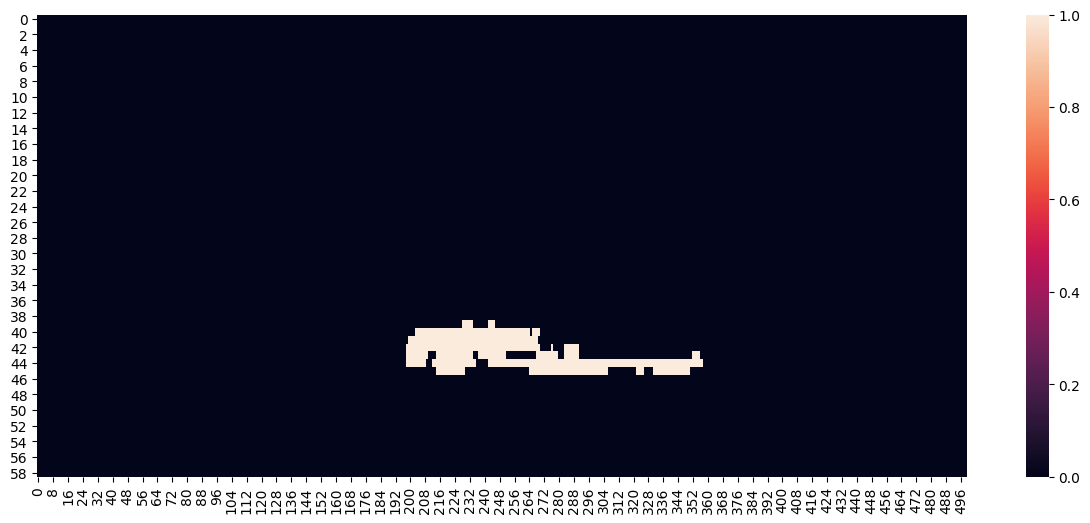

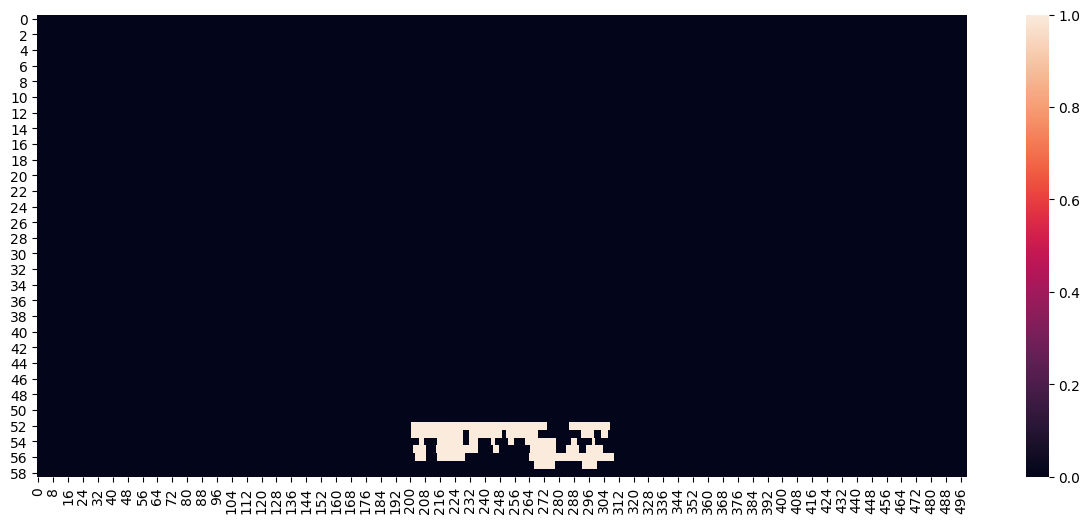

In [ ]:
for i, clu in enumerate(clusters):
    if cluster_p_values[i] < 0.05:
        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        sns.heatmap((clusters[i]))
        #plt.plot((clusters[i][:,14]))

In [ ]:
cluster_p_values

array([1.   , 0.205, 0.878, 0.774, 0.084, 1.   , 1.   , 1.   , 0.716,
       0.588, 1.   , 1.   , 1.   , 0.999, 1.   , 1.   , 1.   , 1.   ,
       1.   , 0.972, 0.14 , 1.   , 0.999, 0.637, 0.728, 1.   , 1.   ,
       1.   , 1.   , 0.98 , 0.999, 0.983, 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 0.228, 1.   , 1.   , 0.507, 0.607, 0.816, 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.983,
       0.41 , 1.   , 0.109, 1.   , 1.   , 1.   , 1.   , 1.   , 0.995,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       0.267, 0.014, 1.   , 1.   , 1.   , 1.   , 0.702, 1.   , 0.997,
       1.   , 0.999, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.999,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.491, 1.   , 0.039,
       1.   , 1.   , 1.   , 0.999, 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   , 1.   , 1.   ])

SyntaxError: invalid syntax (3284442912.py, line 1)

In [ ]:
cluster_p_values


array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       0.04 , 1.   , 1.   , 1.   , 0.015, 1.   , 1.   , 0.168, 0.157,
       1.   , 1.   , 1.   , 1.   , 0.836, 1.   , 1.   , 1.   , 1.   ,
       0.984, 1.   , 1.   , 1.   , 0.999, 0.342, 1.   , 1.   , 0.918,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.03 ,
       1.   , 1.   , 0.13 , 1.   , 1.   , 1.   , 0.993])